# Thought here - feb 23

- what if we train our model with respect to each class one after another one
- this is called **transfer learning**
- we might need to mix some data points of previous attack type to the new attack type, so that the model does not completely forget
about the previous attack and learn completely the new attack, this is called catastrophic forgetting



In [2]:
import pandas as pd

In [8]:
malware = pd.read_csv('smote_malware.csv')
ddos = pd.read_csv('smote_ddos.csv')
intrusion = pd.read_csv('smote_intrusion.csv')

In [10]:
malware = malware.drop('device_os', axis=1)
ddos = ddos.drop('device_os', axis=1)
intrusion = intrusion.drop('device_os', axis=1)

In [17]:
malware.head()

,protocol,packet_length,packet_type,traffic_type,malware_indicators,anomaly_scores,alerts_warnings,attack_signature,action_taken,network_segment,log_source,hour,day,week_day,month,browser,severity_encoded,target
0,UDP,332,1,DNS,1,29,0,Known Pattern B,Blocked,Segment A,1,21,8,1,11,Mozilla,2,Malware
1,UDP,1366,1,HTTP,1,88,0,Known Pattern B,Logged,Segment A,1,19,17,5,7,Mozilla,2,Malware
2,TCP,648,1,HTTP,1,27,1,Known Pattern A,Blocked,Segment C,1,3,20,1,7,Mozilla,1,Malware
3,TCP,1366,1,DNS,0,83,1,Known Pattern A,Blocked,Segment C,1,16,21,1,7,Mozilla,0,Malware
4,ICMP,516,1,HTTP,0,77,0,Known Pattern A,Ignored,Segment A,1,23,25,6,4,Mozilla,0,Malware


# We use SGD

```python
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle

# ===== LOAD DATA =====
df_attack_A = pd.read_csv('attack_A.csv')
df_attack_B = pd.read_csv('attack_B.csv')

X_attack_A = df_attack_A.drop(columns=['attack_type'])
y_attack_A = df_attack_A['attack_type']

X_attack_B = df_attack_B.drop(columns=['attack_type'])
y_attack_B = df_attack_B['attack_type']

# ===== ENCODE TARGET: FIT ON ALL CLASSES =====
y_combined = np.concatenate([y_attack_A, y_attack_B])
le = LabelEncoder()
le.fit(y_combined)  # Fit once on all unique classes

# Transform each dataset
y_attack_A_encoded = le.transform(y_attack_A)
y_attack_B_encoded = le.transform(y_attack_B)

print("All attack classes:", le.classes_)
print("Number of classes:", len(le.classes_))

# Save encoder
pickle.dump(le, open('label_encoder.pkl', 'wb'))

# ===== SPLIT DATA =====
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_attack_A, y_attack_A_encoded, test_size=0.2, 
    random_state=42, stratify=y_attack_A_encoded
)

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_attack_B, y_attack_B_encoded, test_size=0.2, 
    random_state=42, stratify=y_attack_B_encoded
)

# ===== CREATE PREPROCESSOR =====
categorical_cols = ['protocol', 'method']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# ===== CREATE MODEL =====
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(warm_start=True, loss='log_loss'))
])

# ===== TRAIN PHASE 1: Attack A =====
model.fit(X_train_A, y_train_A)
print("\n=== After Training on Attack A ===")
print("Train accuracy:", model.score(X_train_A, y_train_A))
print("Test accuracy:", model.score(X_test_A, y_test_A))

# ===== TRAIN PHASE 2: Mixed A + B =====
X_train_mixed = pd.concat([X_train_A, X_train_B], ignore_index=True)
y_train_mixed = np.concatenate([y_train_A, y_train_B])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_train_mixed),
    y_train_mixed,
    classes=np.unique(y_combined)  # Include all classes
)

print("\n=== After Training on Attack A + B ===")
print("Attack A test accuracy:", model.score(X_test_A, y_test_A))
print("Attack B test accuracy:", model.score(X_test_B, y_test_B))

# ===== MAKE PREDICTIONS =====
y_pred_B = model.predict(X_test_B)
y_pred_text = le.inverse_transform(y_pred_B)
print("\nSample predictions:", y_pred_text[:5])
'''

## label encoding

In [14]:
# load and preprocess data
cat_cols = malware.select_dtypes('object').columns.to_list()

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np

In [18]:
malware_x = malware.drop('target', axis=1)
malware_y = malware['target']

ddos_x = ddos.drop('target', axis=1)
ddos_y = ddos['target']

intrusion_x = intrusion.drop('target', axis=1)
intrusion_y = intrusion['target']

# encode all target - fit all classes
y_combined = np.concatenate([malware_y, ddos_y, intrusion_y])

# label encoder
le = LabelEncoder()
le.fit(y_combined) # fit for all classes

LabelEncoder()

In [23]:
print("All attack classes:", le.classes_)
print("Number of classes:", len(le.classes_))

All attack classes: ['DDoS' 'Intrusion' 'Malware']
Number of classes: 3


In [24]:
# transform each dataset
malware_y_encoded = le.transform(malware_y)
ddos_y_encoded = le.transform(ddos_y)
intrusion_y_encoded = le.transform(intrusion_y)

In [27]:
# save the label encoder
pickle.dump(le, open('label_encoder.pkl', 'wb'))

## split data

In [28]:
X_train_malware, X_test_malware, y_train_malware, y_test_malware = train_test_split(
    malware_x, malware_y_encoded, test_size=0.2, random_state=42, stratify=malware_y_encoded
)

X_train_ddos, X_test_ddos, y_train_ddos, y_test_ddos = train_test_split(
    ddos_x, ddos_y_encoded, test_size=0.2, random_state=42, stratify=ddos_y_encoded
)

X_train_intrusion, X_test_intrusion, y_train_intrusion, y_test_intrusion = train_test_split(
    intrusion_x, intrusion_y_encoded, test_size=0.2, random_state=42, stratify=intrusion_y_encoded
)

In [39]:
print("Intrusion: ", X_train_intrusion.shape, X_test_intrusion.shape)

Intrusion:  (1280, 17) (320, 17)


## create processor

In [48]:
cat_cols = X_train_intrusion.select_dtypes('object').columns.to_list()
num_cols = ['packet_length', 'anomaly_scores']

# preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

## Create Model - SGD Classifier

In [80]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(warm_start=True, loss='log_loss', max_iter=500))
])

### training phase 1

In [81]:
dummy_size = 50
X_phase1 = pd.concat([X_train_malware, X_train_ddos.iloc[:dummy_size]], ignore_index=True)
y_phase1 = np.concatenate([y_train_malware, y_train_ddos[:dummy_size]])

# Use partial_fit instead of fit() and specify all 3 classes
model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase1),
    y_phase1,
    classes=np.array([0, 1, 2])  # All 3 classes from the start
)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",500
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [82]:
print("Attack A test accuracy:", model.score(X_test_malware, y_test_malware))
print("Attack B test accuracy:", model.score(X_test_ddos, y_test_ddos))

Attack A test accuracy: 1.0
Attack B test accuracy: 0.0


In [83]:
# Save checkpoint after Phase 1
pickle.dump(model, open('model_phase1.pkl', 'wb'))

### training phase 2

In [84]:
X_train_mixed = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[dummy_size:]
], ignore_index=True)

y_train_mixed = pd.concat([
    pd.Series(y_train_malware),
    pd.Series(y_train_ddos[dummy_size:])
], ignore_index=True)

# use partial weights
# Use partial_fit to continue from Phase 1 weights
model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_train_mixed),
    y_train_mixed,
    classes=np.array([0, 1, 2])
)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",500
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [85]:
print("Attack A test accuracy:", model.score(X_test_malware, y_test_malware))
print(f"Attack B test accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")


Attack A test accuracy: 0.35625
Attack B test accuracy: 0.3375


In [86]:
# Save checkpoint after Phase 2
pickle.dump(model, open('model_phase2.pkl', 'wb'))

### training phase 3

In [87]:
X_train_mixed_3 = pd.concat([
    X_train_ddos,
    X_train_intrusion.iloc[dummy_size:]
], ignore_index=True)

y_train_mixed_3 = pd.concat([
    pd.Series(y_train_ddos),
    pd.Series(y_train_intrusion[dummy_size:])
], ignore_index=True)

# use partial weights
# Use partial_fit to continue from Phase 1 weights
model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_train_mixed_3),
    y_train_mixed_3,
    classes=np.array([0, 1, 2])
)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",500
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [88]:
print(f"Attack B test accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Attack B test accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")

Attack B test accuracy: 0.1906
Attack B test accuracy: 0.9219


## Testing part

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [90]:
le = pickle.load(open('label_encoder.pkl', 'rb'))

X_test_combined = pd.concat([
    X_test_malware,
    X_test_ddos,
    X_test_intrusion
], ignore_index=True)

y_test_combined = np.concatenate([
    y_test_malware,
    y_test_ddos,
    y_test_intrusion
])

y_pred_combined = model.predict(X_test_combined)

In [91]:
# ===== OVERALL ACCURACY =====
overall_accuracy = accuracy_score(y_test_combined, y_pred_combined)
print("=== COMBINED TEST SET EVALUATION ===")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===== DETAILED CLASSIFICATION REPORT =====
print("\n=== Classification Report ===")
print(classification_report(
    y_test_combined, 
    y_pred_combined,
    target_names=le.classes_
))


=== COMBINED TEST SET EVALUATION ===
Overall Accuracy: 0.3708

=== Classification Report ===
              precision    recall  f1-score   support

        DDoS       0.52      0.19      0.28       320
   Intrusion       0.35      0.92      0.51       320
     Malware       0.00      0.00      0.00       320

    accuracy                           0.37       960
   macro avg       0.29      0.37      0.26       960
weighted avg       0.29      0.37      0.26       960



/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

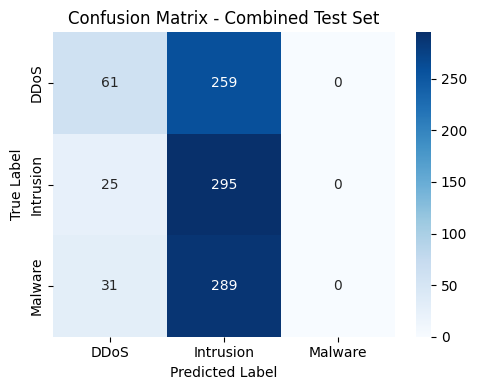

In [95]:
import seaborn as sns
# ===== CONFUSION MATRIX =====
cm = confusion_matrix(y_test_combined, y_pred_combined)

# ===== VISUALIZE CONFUSION MATRIX =====
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix - Combined Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [96]:
# ===== PER-CLASS ACCURACY =====
print("\n=== Per-Class Accuracy ===")
print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")


=== Per-Class Accuracy ===
Malware accuracy: 0.0000
DDoS accuracy: 0.1906
Intrusion accuracy: 0.9219


Here we say that our approach works, but the model is frogetting what it has learnt in the phase 1, so now we try to increase the size of data points.

## Create model - SGD Classifier - Part 2

In [ ]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier
    (warm_start=True, loss='log_loss', max_iter=500))
])

### phase 1

In [169]:
from sklearn.utils import shuffle

# Define dummy sizes
dummy_size_ddos = 200
dummy_size_intrusion = 100

# ===== PHASE 1: Malware + Dummy DDoS + Dummy Intrusion =====
print("=== PHASE 1: Malware + Dummy DDoS + Dummy Intrusion ===")
X_phase1 = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[:dummy_size_ddos],
    X_train_intrusion.iloc[:dummy_size_intrusion]
], ignore_index=True)

y_phase1 = np.concatenate([
    y_train_malware,
    y_train_ddos[:dummy_size_ddos],
    y_train_intrusion[:dummy_size_intrusion]
])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase1),
    y_phase1,
    classes=np.array([0, 1, 2])
)

print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")

=== PHASE 1: Malware + Dummy DDoS + Dummy Intrusion ===
Malware accuracy: 0.9812
DDoS accuracy: 0.0156
Intrusion accuracy: 0.0938


### phase 2

In [170]:
print("\n=== PHASE 2: Full Malware + Full DDoS + Dummy Intrusion ===")
X_phase2 = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[dummy_size_ddos:],  # Remaining DDoS
    X_train_intrusion.iloc[:dummy_size_intrusion]  # Same dummy Intrusion
], ignore_index=True)

y_phase2 = np.concatenate([
    y_train_malware,
    y_train_ddos[dummy_size_ddos:],
    y_train_intrusion[:dummy_size_intrusion]
])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase2),
    y_phase2,
    classes=np.array([0, 1, 2])
)

print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")



=== PHASE 2: Full Malware + Full DDoS + Dummy Intrusion ===
Malware accuracy: 0.9094
DDoS accuracy: 0.1969
Intrusion accuracy: 0.0281


### phase 3

In [171]:
print("\n=== PHASE 3: Full Malware + Full DDoS + Full Intrusion ===")
X_phase3 = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[dummy_size_ddos:],
    X_train_intrusion.iloc[dummy_size_intrusion:]  # Remaining Intrusion
], ignore_index=True)

y_phase3 = np.concatenate([
    y_train_malware,
    y_train_ddos[dummy_size_ddos:],
    y_train_intrusion[dummy_size_intrusion:]
])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase3),
    y_phase3,
    classes=np.array([0, 1, 2])
)

print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")


=== PHASE 3: Full Malware + Full DDoS + Full Intrusion ===
Malware accuracy: 0.4844
DDoS accuracy: 0.6219
Intrusion accuracy: 0.3344


In [172]:
print("\n=== COMBINED TEST SET ===")
X_test_combined = pd.concat([X_test_malware, X_test_ddos, X_test_intrusion], ignore_index=True)
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

y_pred_combined = model.predict(X_test_combined)
overall_accuracy = np.mean(y_pred_combined == y_test_combined)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")


=== COMBINED TEST SET ===
Overall Accuracy: 0.4802
Malware accuracy: 0.4844
DDoS accuracy: 0.6219
Intrusion accuracy: 0.3344


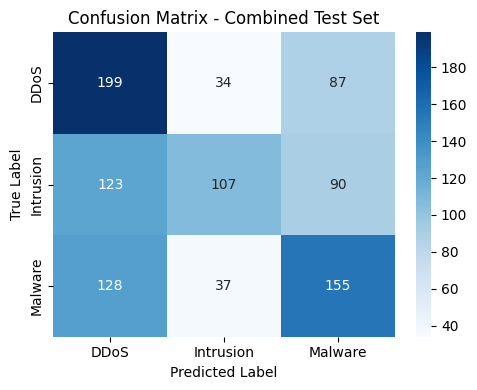

In [173]:
import seaborn as sns
# ===== CONFUSION MATRIX =====
cm = confusion_matrix(y_test_combined, y_pred_combined)

# ===== VISUALIZE CONFUSION MATRIX =====
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix - Combined Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [174]:
# Save checkpoint after Phase 2
pickle.dump(model, open('test/test3/model_test_2.pkl', 'wb'))

# Model 2 - Multi Layer Perceptron (MLP)

=== MLP CLASSIFIER WITH INCREMENTAL LEARNING ===

=== PHASE 1: Focus on Malware ===
Training data distribution:
  Malware: 896
  DDoS: 268
  Intrusion: 134

Malware: 0.9844 | DDoS: 0.0437 | Intrusion: 0.0281

=== PHASE 2: Add DDoS Data ===
Training data distribution:
  Malware: 896
  DDoS: 627
  Intrusion: 179

Malware: 0.5563 | DDoS: 0.7000 | Intrusion: 0.0406

=== PHASE 3: Add Intrusion Data ===
Training data distribution:
  Malware: 896
  DDoS: 896
  Intrusion: 896

Malware: 0.3187 | DDoS: 0.7375 | Intrusion: 0.4125

=== COMBINED TEST SET ===
Overall Accuracy: 0.4896
Malware accuracy: 0.3187
DDoS accuracy: 0.7375
Intrusion accuracy: 0.4125

=== Classification Report ===
              precision    recall  f1-score   support

        DDoS       0.43      0.74      0.54       320
   Intrusion       0.60      0.41      0.49       320
     Malware       0.55      0.32      0.40       320

    accuracy                           0.49       960
   macro avg       0.52      0.49      0.48   

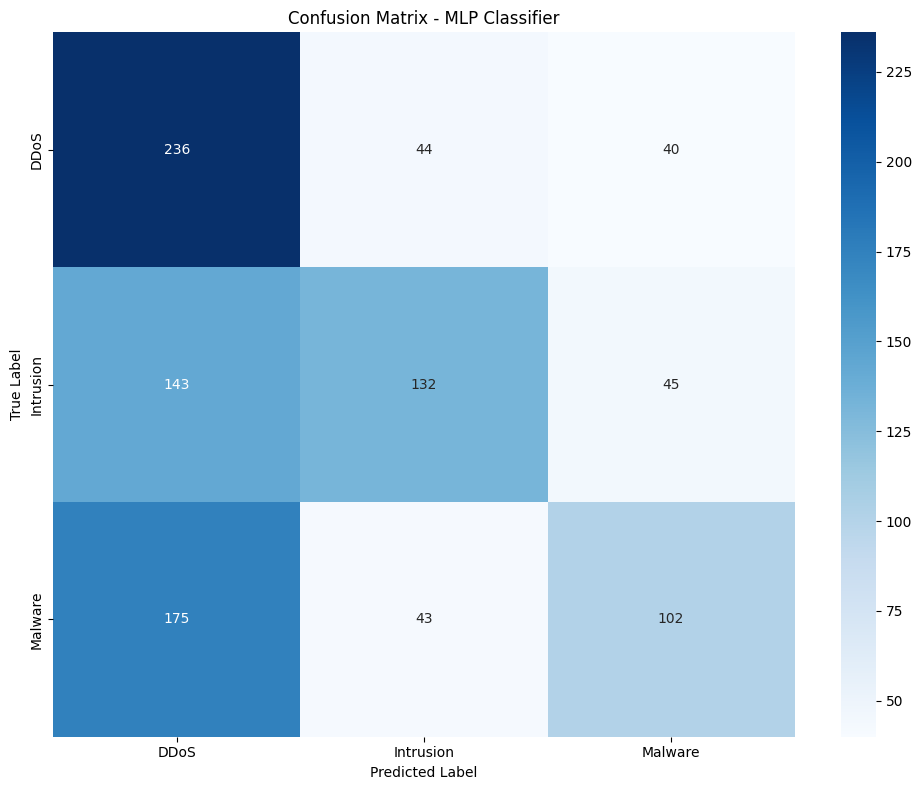

In [201]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle

# ===== ENCODE TARGET =====
# y_combined = np.concatenate([y_train_malware, y_train_ddos, y_train_intrusion])
# le = LabelEncoder()
# le.fit(y_combined)

# y_train_malware_encoded = le.transform(y_train_malware)
# y_train_ddos_encoded = le.transform(y_train_ddos)
# y_train_intrusion_encoded = le.transform(y_train_intrusion)

# y_test_malware_encoded = le.transform(y_test_malware)
# y_test_ddos_encoded = le.transform(y_test_ddos)
# y_test_intrusion_encoded = le.transform(y_test_intrusion)

# print("All attack classes:", le.classes_)
# pickle.dump(le, open('label_encoder_mlp.pkl', 'wb'))

# # ===== CREATE PREPROCESSOR =====
# numerical_cols = ['duration', 'bytes_sent']
# categorical_cols = ['protocol', 'method']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ]
# )

# ===== CREATE MLP MODEL =====
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(64),  # 3 hidden layers
        activation='relu',                  # ReLU activation function
        solver='adam',                      # Adam optimizer (good for neural networks)
        learning_rate_init=0.01,           # Initial learning rate
        max_iter=1000,                       # Max iterations per partial_fit call
        warm_start=True,                    # Enable incremental learning
        # early_stopping=True,                # Stop early if validation score plateaus
        # validation_fraction=0.1,            # Use 10% for validation
        # n_iter_no_change=10,                # Stop if no improvement for 10 iterations
        random_state=42,
        # verbose=True
    ))
])

print("=== MLP CLASSIFIER WITH INCREMENTAL LEARNING ===\n")

# Define split sizes
split_malware = int(len(X_train_malware) * 0.7)
split_ddos = int(len(X_train_ddos) * 0.7)
split_intrusion = int(len(X_train_intrusion) * 0.7)

# ===== PHASE 1: Focus on Malware =====
print("=== PHASE 1: Focus on Malware ===")
X_phase1 = pd.concat([
    X_train_malware.iloc[:split_malware],
    X_train_ddos.iloc[:int(split_ddos * 0.3)],
    X_train_intrusion.iloc[:int(split_intrusion * 0.15)]
], ignore_index=True)

y_phase1 = np.concatenate([
    y_train_malware[:split_malware],
    y_train_ddos[:int(split_ddos * 0.3)],
    y_train_intrusion[:int(split_intrusion * 0.15)]
])

print(f"Training data distribution:")
print(f"  Malware: {split_malware}")
print(f"  DDoS: {int(split_ddos * 0.3)}")
print(f"  Intrusion: {int(split_intrusion * 0.15)}\n")

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase1),
    y_phase1,
    classes=np.array([0, 1, 2])
)

malware_acc = model.score(X_test_malware, y_test_malware)
ddos_acc = model.score(X_test_ddos, y_test_ddos)
intrusion_acc = model.score(X_test_intrusion, y_test_intrusion)

print(f"Malware: {malware_acc:.4f} | DDoS: {ddos_acc:.4f} | Intrusion: {intrusion_acc:.4f}\n")
pickle.dump(model, open('model_mlp_phase1.pkl', 'wb'))

# ===== PHASE 2: Add DDoS =====
print("=== PHASE 2: Add DDoS Data ===")
X_phase2 = pd.concat([
    X_train_malware.iloc[:split_malware],
    X_train_ddos.iloc[:int(split_ddos * 0.7)],
    X_train_intrusion.iloc[:int(split_intrusion * 0.2)]
], ignore_index=True)

y_phase2 = np.concatenate([
    y_train_malware[:split_malware],
    y_train_ddos[:int(split_ddos * 0.7)],
    y_train_intrusion[:int(split_intrusion * 0.2)]
])

print(f"Training data distribution:")
print(f"  Malware: {split_malware}")
print(f"  DDoS: {int(split_ddos * 0.7)}")
print(f"  Intrusion: {int(split_intrusion * 0.2)}\n")

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase2),
    y_phase2,
    classes=np.array([0, 1, 2])
)

malware_acc = model.score(X_test_malware, y_test_malware)
ddos_acc = model.score(X_test_ddos, y_test_ddos)
intrusion_acc = model.score(X_test_intrusion, y_test_intrusion)

print(f"Malware: {malware_acc:.4f} | DDoS: {ddos_acc:.4f} | Intrusion: {intrusion_acc:.4f}\n")
pickle.dump(model, open('model_mlp_phase2.pkl', 'wb'))

# ===== PHASE 3: Add Intrusion =====
print("=== PHASE 3: Add Intrusion Data ===")
X_phase3 = pd.concat([
    X_train_malware.iloc[:split_malware],
    X_train_ddos.iloc[:split_ddos],
    X_train_intrusion.iloc[:split_intrusion]
], ignore_index=True)

y_phase3 = np.concatenate([
    y_train_malware[:split_malware],
    y_train_ddos[:split_ddos],
    y_train_intrusion[:split_intrusion]
])

print(f"Training data distribution:")
print(f"  Malware: {split_malware}")
print(f"  DDoS: {split_ddos}")
print(f"  Intrusion: {split_intrusion}\n")

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase3),
    y_phase3,
    classes=np.array([0, 1, 2])
)

malware_acc = model.score(X_test_malware, y_test_malware)
ddos_acc = model.score(X_test_ddos, y_test_ddos)
intrusion_acc = model.score(X_test_intrusion, y_test_intrusion)

print(f"Malware: {malware_acc:.4f} | DDoS: {ddos_acc:.4f} | Intrusion: {intrusion_acc:.4f}\n")
pickle.dump(model, open('model_mlp_phase3.pkl', 'wb'))

# ===== COMBINED TEST SET =====
print("=== COMBINED TEST SET ===")
X_test_combined = pd.concat([X_test_malware, X_test_ddos, X_test_intrusion], ignore_index=True)
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

y_pred_combined = model.predict(X_test_combined)
overall_accuracy = np.mean(y_pred_combined == y_test_combined)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")

# ===== DETAILED EVALUATION =====
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Classification Report ===")
print(classification_report(y_test_combined, y_pred_combined, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_combined, y_pred_combined)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix - MLP Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
pickle.dump(model, open('test/test3/model_test_mlp.pkl', 'wb'))

# Thought here

- Models which are good are SGD and MLP (Multi layer perceptron)

<br>

**THOUGHT HERE**
- we try to implement best features and rerun the model of SGD and MLP
- we then try to do PCA and build a model in SGD and NLP

# Model 3 - Feature Selection Models 

## Feature selection

In [206]:
# combine the dataset
X_train_combined = pd.concat([X_train_malware, X_train_ddos, X_train_intrusion], ignore_index=True)
y_train_combined = np.concatenate([y_train_malware, y_train_ddos, y_train_intrusion])

# Preprocess (scale and encode)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train_processed = preprocessor.fit_transform(X_train_combined)
print(f"Features after preprocessing: {X_train_processed.shape[1]}")  # e.g., 25 features

# Select best 10 features
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_processed, y_train_combined)
print(f"Features after selection: {X_train_selected.shape[1]}")  # 10 features

Features after preprocessing: 18
Features after selection: 10


In [208]:
# 4. Apply same selection to test data
X_test_processed = preprocessor.transform(X_test_combined)
X_test_selected = selector.transform(X_test_processed)

## model building on features

In [230]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X_test_malware_processed = preprocessor.transform(X_test_malware)
X_test_malware_selected = selector.transform(X_test_malware_processed)

X_test_ddos_processed = preprocessor.transform(X_test_ddos)
X_test_ddos_selected = selector.transform(X_test_ddos_processed)

X_test_intrusion_processed = preprocessor.transform(X_test_intrusion)
X_test_intrusion_selected = selector.transform(X_test_intrusion_processed)

# ===== STEP 1: Create Model =====
model_sgd = SGDClassifier(
    warm_start=True,
    loss='log_loss',
    max_iter=5000,
    # random_state=42
)

# ===== STEP 2: Train =====
model_sgd.fit(X_train_selected, y_train_combined)

# ===== STEP 3: Predict on Test Sets =====
y_pred_malware = model_sgd.predict(X_test_malware_selected)
y_pred_ddos = model_sgd.predict(X_test_ddos_selected)
y_pred_intrusion = model_sgd.predict(X_test_intrusion_selected)

# ===== STEP 4: Evaluate =====
print("Malware Accuracy:", accuracy_score(y_test_malware, y_pred_malware))
print("DDoS Accuracy:", accuracy_score(y_test_ddos, y_pred_ddos))
print("Intrusion Accuracy:", accuracy_score(y_test_intrusion, y_pred_intrusion))

# Combined
y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
print("Combined Accuracy:", accuracy_score(y_test_all, y_pred_all))

Malware Accuracy: 0.234375
DDoS Accuracy: 0.41875
Intrusion Accuracy: 0.6
Combined Accuracy: 0.41770833333333335


## MNLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===== STEP 1: Create MLP Model =====
model_mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=500,
    warm_start=True,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# ===== STEP 2: Train =====
model_mlp.fit(X_train_selected, y_train_combined)

# ===== STEP 3: Predict on Test Sets =====
y_pred_malware = model_mlp.predict(X_test_malware_selected)
y_pred_ddos = model_mlp.predict(X_test_ddos_selected)
y_pred_intrusion = model_mlp.predict(X_test_intrusion_selected)

# ===== STEP 4: Evaluate =====
print("Malware Accuracy:", accuracy_score(y_test_malware, y_pred_malware))
print("DDoS Accuracy:", accuracy_score(y_test_ddos, y_pred_ddos))
print("Intrusion Accuracy:", accuracy_score(y_test_intrusion, y_pred_intrusion))

# Combined
y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
print("Combined Accuracy:", accuracy_score(y_test_all, y_pred_all))

Malware Accuracy: 0.53125
DDoS Accuracy: 0.584375
Intrusion Accuracy: 0.390625
Combined Accuracy: 0.5020833333333333


In [232]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===== STEP 1: Create MLP Model =====
model_mlp = MLPClassifier(
    hidden_layer_sizes=(64),  # 3 hidden layers
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=500,
    warm_start=True,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# ===== STEP 2: Train =====
model_mlp.fit(X_train_selected, y_train_combined)

# ===== STEP 3: Predict on Test Sets =====
y_pred_malware = model_mlp.predict(X_test_malware_selected)
y_pred_ddos = model_mlp.predict(X_test_ddos_selected)
y_pred_intrusion = model_mlp.predict(X_test_intrusion_selected)

# ===== STEP 4: Evaluate =====
print("Malware Accuracy:", accuracy_score(y_test_malware, y_pred_malware))
print("DDoS Accuracy:", accuracy_score(y_test_ddos, y_pred_ddos))
print("Intrusion Accuracy:", accuracy_score(y_test_intrusion, y_pred_intrusion))

# Combined
y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
print("Combined Accuracy:", accuracy_score(y_test_all, y_pred_all))

Malware Accuracy: 0.528125
DDoS Accuracy: 0.665625
Intrusion Accuracy: 0.26875
Combined Accuracy: 0.4875


In [242]:
model_mlp = MLPClassifier(
    hidden_layer_sizes=(64),  # 3 hidden layers
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=200,
    warm_start=True,
    early_stopping=True,
    validation_fraction=0.1,
    # random_state=42
)

# ===== STEP 2: Train =====
model_mlp.fit(X_train_selected, y_train_combined)

# ===== STEP 3: Predict on Test Sets =====
y_pred_malware = model_mlp.predict(X_test_malware_selected)
y_pred_ddos = model_mlp.predict(X_test_ddos_selected)
y_pred_intrusion = model_mlp.predict(X_test_intrusion_selected)

# ===== STEP 4: Evaluate =====
print("Malware Accuracy:", accuracy_score(y_test_malware, y_pred_malware))
print("DDoS Accuracy:", accuracy_score(y_test_ddos, y_pred_ddos))
print("Intrusion Accuracy:", accuracy_score(y_test_intrusion, y_pred_intrusion))

# Combined
y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
print("Combined Accuracy:", accuracy_score(y_test_all, y_pred_all))

Malware Accuracy: 0.66875
DDoS Accuracy: 0.45625
Intrusion Accuracy: 0.315625
Combined Accuracy: 0.48020833333333335


## Hyperparameter tuning

MLP HYPERPARAMETER TUNING

STEP 1: DEFINE PARAMETER RANGES TO TEST

Learning rates to test: [0.0001, 0.0005, 0.001, 0.005, 0.01]
Max iterations to test: [200, 300, 500, 700, 1000, 5000, 10000]
Total combinations: 35

STEP 2: TRAIN AND TEST ALL COMBINATIONS

[1/35] Testing: lr=0.0001, max_iter=200
  Train Accuracy: 0.3732
  Combined Test Accuracy: 0.3802
  Training Time: 0.19s

[2/35] Testing: lr=0.0001, max_iter=300
  Train Accuracy: 0.3630
  Combined Test Accuracy: 0.3500
  Training Time: 0.08s

[3/35] Testing: lr=0.0001, max_iter=500
  Train Accuracy: 0.4599
  Combined Test Accuracy: 0.4417
  Training Time: 0.19s

[4/35] Testing: lr=0.0001, max_iter=700
  Train Accuracy: 0.3401
  Combined Test Accuracy: 0.3375
  Training Time: 0.04s

[5/35] Testing: lr=0.0001, max_iter=1000
  Train Accuracy: 0.4383
  Combined Test Accuracy: 0.4240
  Training Time: 0.09s

[6/35] Testing: lr=0.0001, max_iter=5000
  Train Accuracy: 0.4583
  Combined Test Accuracy: 0.4365
  Training Time: 0.16s

[7/35] T

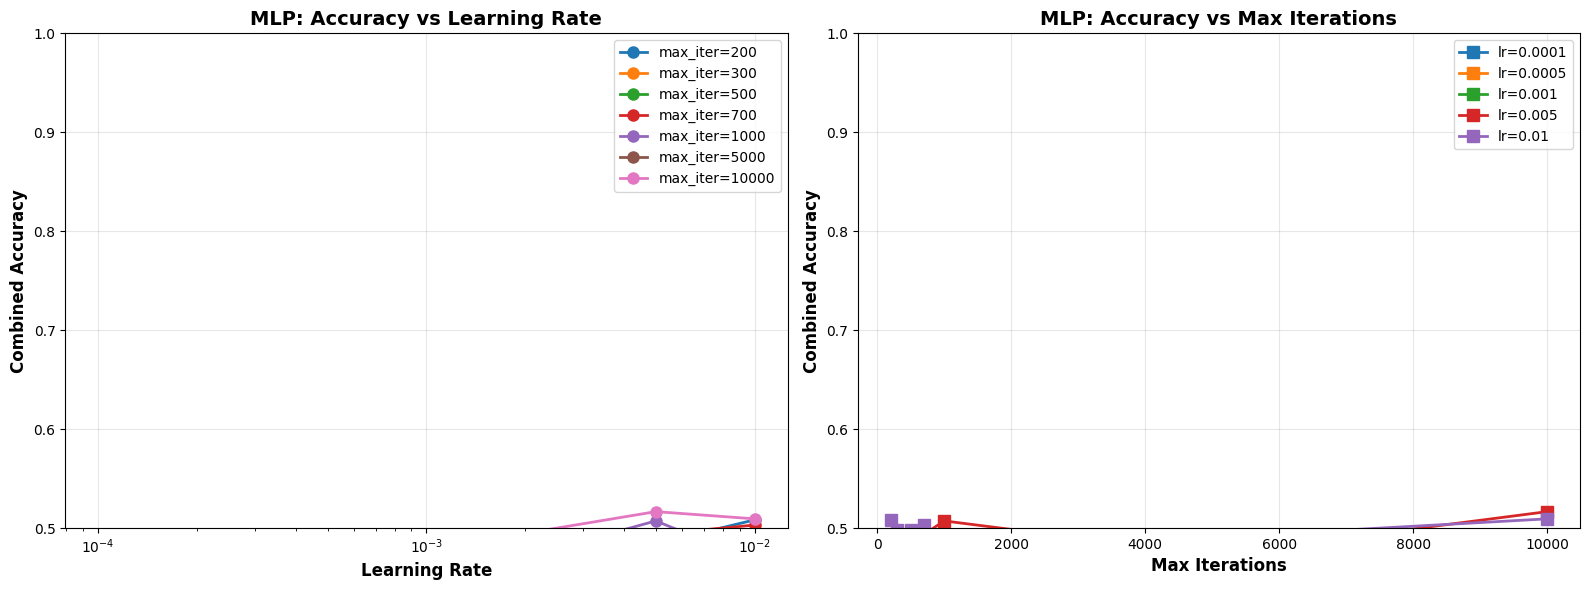


Generating heatmap...


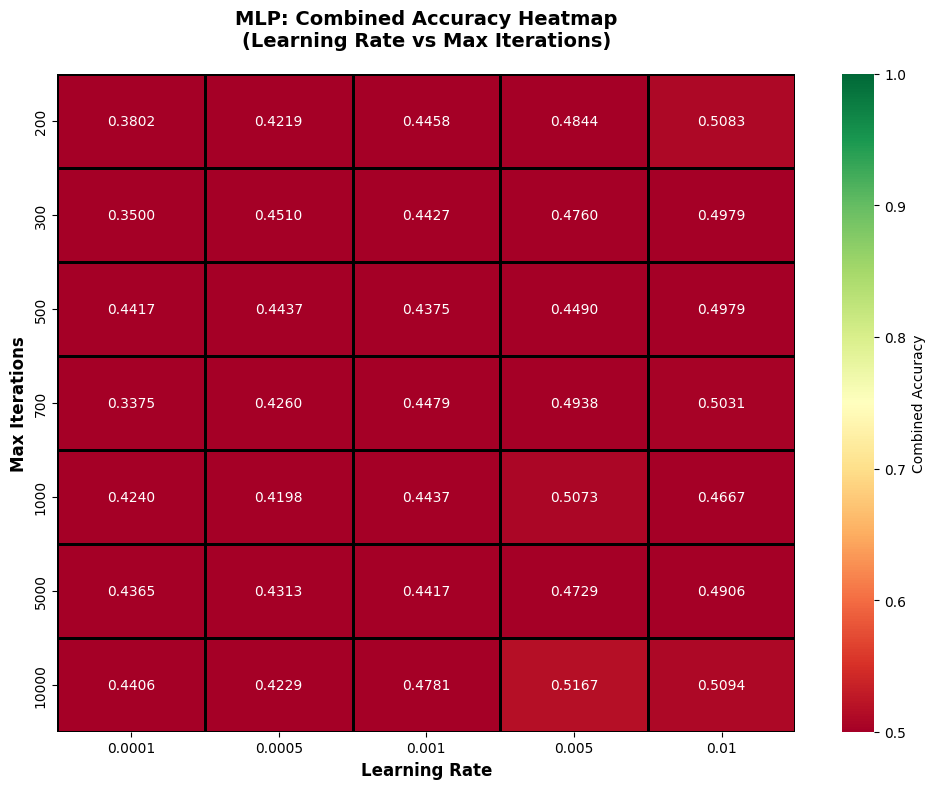

Generating per-class accuracy plot...


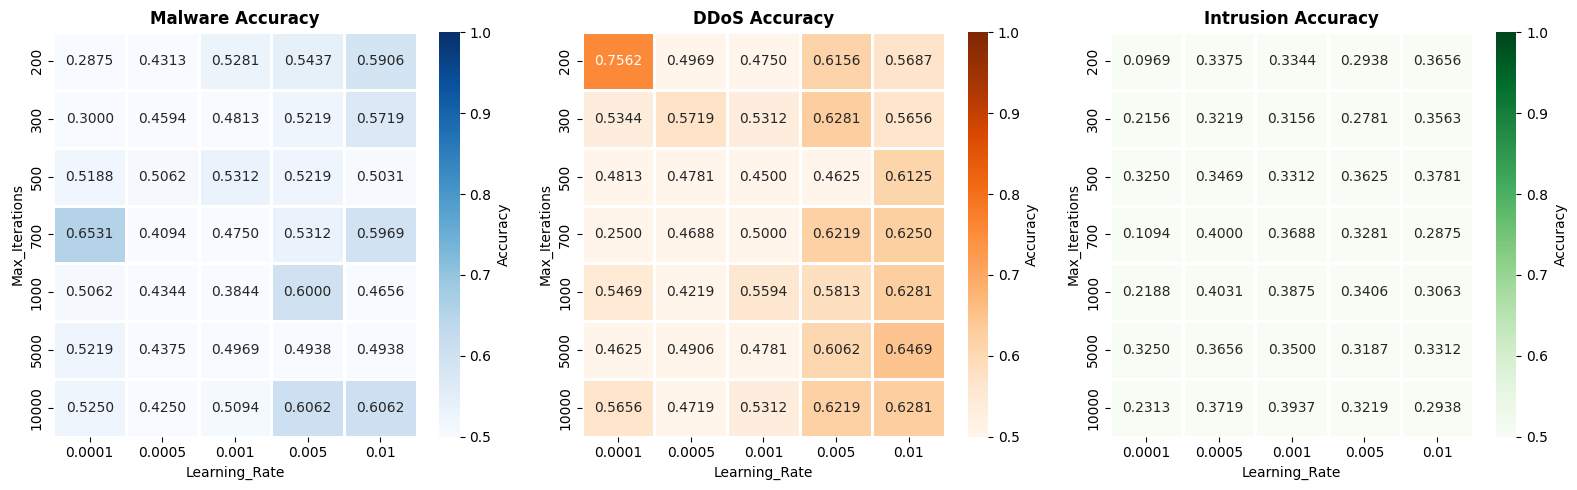


STEP 6: SUMMARY TABLE

 Learning_Rate  Max_Iterations  Train_Accuracy  Malware_Accuracy  DDoS_Accuracy  Intrusion_Accuracy  Combined_Accuracy  Macro_F1  Training_Time
        0.0001             200        0.373177          0.287500       0.756250            0.096875           0.380208  0.329954       0.194790
        0.0001             300        0.363021          0.300000       0.534375            0.215625           0.350000  0.337837       0.079811
        0.0001             500        0.459896          0.518750       0.481250            0.325000           0.441667  0.437407       0.193807
        0.0001             700        0.340104          0.653125       0.250000            0.109375           0.337500  0.301728       0.037550
        0.0001            1000        0.438281          0.506250       0.546875            0.218750           0.423958  0.409763       0.094371
        0.0001            5000        0.458333          0.521875       0.462500            0.325000           0.

In [245]:
"""
MLP HYPERPARAMETER TUNING
Test different learning rates and max iterations to find the best combination
for maximum accuracy
"""

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("MLP HYPERPARAMETER TUNING")
print("="*80)

# ===== ASSUMPTION =====
# You have:
# - X_train_selected, y_train_combined (training data with selected features)
# - X_test_malware_selected, X_test_ddos_selected, X_test_intrusion_selected
# - y_test_malware, y_test_ddos, y_test_intrusion

# ===== DEFINE PARAMETER RANGES =====
print("\n" + "="*80)
print("STEP 1: DEFINE PARAMETER RANGES TO TEST")
print("="*80)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
max_iterations = [200, 300, 500, 700, 1000, 5000, 10000]

print(f"\nLearning rates to test: {learning_rates}")
print(f"Max iterations to test: {max_iterations}")
print(f"Total combinations: {len(learning_rates) * len(max_iterations)}")

# ===== TEST ALL COMBINATIONS =====
print("\n" + "="*80)
print("STEP 2: TRAIN AND TEST ALL COMBINATIONS")
print("="*80)

results = []
total_tests = len(learning_rates) * len(max_iterations)
current_test = 0

for lr in learning_rates:
    for max_iter in max_iterations:
        current_test += 1
        print(f"\n[{current_test}/{total_tests}] Testing: lr={lr}, max_iter={max_iter}")
        
        # Create MLP model
        mlp_model = MLPClassifier(
            hidden_layer_sizes=(64),
            activation='relu',
            solver='adam',
            learning_rate_init=lr,
            max_iter=max_iter,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            # random_state=42,
            verbose=0
        )
        
        # Train model
        start_time = time.time()
        mlp_model.fit(X_train_selected, y_train_combined)
        training_time = time.time() - start_time
        
        # Make predictions on training data
        y_train_pred = mlp_model.predict(X_train_selected)
        train_accuracy = accuracy_score(y_train_combined, y_train_pred)
        
        # Make predictions on test data (individual attack types)
        y_pred_malware = mlp_model.predict(X_test_malware_selected)
        y_pred_ddos = mlp_model.predict(X_test_ddos_selected)
        y_pred_intrusion = mlp_model.predict(X_test_intrusion_selected)
        
        # Calculate accuracy for each attack type
        malware_accuracy = accuracy_score(y_test_malware, y_pred_malware)
        ddos_accuracy = accuracy_score(y_test_ddos, y_pred_ddos)
        intrusion_accuracy = accuracy_score(y_test_intrusion, y_pred_intrusion)
        
        # Combine all test predictions and labels
        y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
        y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
        
        # Calculate combined accuracy and F1 score
        combined_accuracy = accuracy_score(y_test_all, y_pred_all)
        macro_f1 = f1_score(y_test_all, y_pred_all, average='macro')
        
        # Print results for this combination
        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Combined Test Accuracy: {combined_accuracy:.4f}")
        print(f"  Training Time: {training_time:.2f}s")
        
        # Store results
        results.append({
            'Learning_Rate': lr,
            'Max_Iterations': max_iter,
            'Training_Time': training_time,
            'Train_Accuracy': train_accuracy,
            'Malware_Accuracy': malware_accuracy,
            'DDoS_Accuracy': ddos_accuracy,
            'Intrusion_Accuracy': intrusion_accuracy,
            'Combined_Accuracy': combined_accuracy,
            'Macro_F1': macro_f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# ===== FIND BEST CONFIGURATION =====
print("\n" + "="*80)
print("STEP 3: FIND BEST CONFIGURATION")
print("="*80)

best_idx = results_df['Combined_Accuracy'].idxmax()
best_config = results_df.loc[best_idx]

print(f"\n✓ BEST CONFIGURATION FOUND:")
print(f"  Learning Rate: {best_config['Learning_Rate']}")
print(f"  Max Iterations: {int(best_config['Max_Iterations'])}")
print(f"  Combined Test Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Training Time: {best_config['Training_Time']:.2f}s")
print(f"\n  Per-class Accuracy:")
print(f"    - Malware:    {best_config['Malware_Accuracy']:.4f}")
print(f"    - DDoS:       {best_config['DDoS_Accuracy']:.4f}")
print(f"    - Intrusion:  {best_config['Intrusion_Accuracy']:.4f}")
print(f"    - Macro F1:   {best_config['Macro_F1']:.4f}")

# ===== TOP 5 CONFIGURATIONS =====
print("\n" + "="*80)
print("STEP 4: TOP 5 CONFIGURATIONS")
print("="*80)

top_5 = results_df.nlargest(5, 'Combined_Accuracy')
print("\n" + top_5[['Learning_Rate', 'Max_Iterations', 'Combined_Accuracy', 
                     'Training_Time']].to_string(index=False))

# ===== VISUALIZATION 1: LINE PLOTS =====
print("\n" + "="*80)
print("STEP 5: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy vs Learning Rate
ax = axes[0]
for max_iter in max_iterations:
    subset = results_df[results_df['Max_Iterations'] == max_iter]
    ax.plot(subset['Learning_Rate'], subset['Combined_Accuracy'], 
            marker='o', label=f'max_iter={max_iter}', linewidth=2, markersize=8)

ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP: Accuracy vs Learning Rate', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_ylim([0.5, 1.0])

# Plot 2: Accuracy vs Max Iterations
ax = axes[1]
for lr in learning_rates:
    subset = results_df[results_df['Learning_Rate'] == lr]
    ax.plot(subset['Max_Iterations'], subset['Combined_Accuracy'], 
            marker='s', label=f'lr={lr}', linewidth=2, markersize=8)

ax.set_xlabel('Max Iterations', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP: Accuracy vs Max Iterations', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# ===== VISUALIZATION 2: HEATMAP =====
print("\nGenerating heatmap...")

# Create pivot table
heatmap_data = results_df.pivot_table(
    values='Combined_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Combined Accuracy'}, 
            vmin=0.5, vmax=1.0, linewidths=1, linecolor='black')

plt.title('MLP: Combined Accuracy Heatmap\n(Learning Rate vs Max Iterations)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Max Iterations', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 3: PER-CLASS ACCURACY =====
print("Generating per-class accuracy plot...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Malware accuracy
ax = axes[0]
malware_pivot = results_df.pivot_table(
    values='Malware_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(malware_pivot, annot=True, fmt='.4f', cmap='Blues', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Malware Accuracy', fontsize=12, fontweight='bold')

# DDoS accuracy
ax = axes[1]
ddos_pivot = results_df.pivot_table(
    values='DDoS_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(ddos_pivot, annot=True, fmt='.4f', cmap='Oranges', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('DDoS Accuracy', fontsize=12, fontweight='bold')

# Intrusion accuracy
ax = axes[2]
intrusion_pivot = results_df.pivot_table(
    values='Intrusion_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(intrusion_pivot, annot=True, fmt='.4f', cmap='Greens', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Intrusion Accuracy', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ===== SUMMARY TABLE =====
print("\n" + "="*80)
print("STEP 6: SUMMARY TABLE")
print("="*80)

summary_df = results_df[['Learning_Rate', 'Max_Iterations', 'Train_Accuracy',
                          'Malware_Accuracy', 'DDoS_Accuracy', 'Intrusion_Accuracy',
                          'Combined_Accuracy', 'Macro_F1', 'Training_Time']].copy()

print("\n" + summary_df.to_string(index=False))

# ===== RECOMMENDATIONS =====
print("\n" + "="*80)
print("STEP 7: RECOMMENDATIONS")
print("="*80)

print(f"\n✓ USE THESE PARAMETERS FOR BEST ACCURACY:")
print(f"  model = MLPClassifier(")
print(f"      hidden_layer_sizes=(64),")
print(f"      activation='relu',")
print(f"      solver='adam',")
print(f"      learning_rate_init={best_config['Learning_Rate']},")
print(f"      max_iter={int(best_config['Max_Iterations'])},")
print(f"      early_stopping=True,")
print(f"      validation_fraction=0.1,")
print(f"      n_iter_no_change=10,")
print(f"      random_state=42")
print(f"  )")
print(f"\nExpected Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")

print("\n" + "="*80)
print("✓ HYPERPARAMETER TUNING COMPLETE!")
print("="*80)

In [246]:
results_df

,Learning_Rate,Max_Iterations,Training_Time,Train_Accuracy,Malware_Accuracy,DDoS_Accuracy,Intrusion_Accuracy,Combined_Accuracy,Macro_F1
0,0.0001,200,0.194790,0.373177,0.287500,0.756250,0.096875,0.380208,0.329954
1,0.0001,300,0.079811,0.363021,0.300000,0.534375,0.215625,0.350000,0.337837
2,0.0001,500,0.193807,0.459896,0.518750,0.481250,0.325000,0.441667,0.437407
3,0.0001,700,0.037550,0.340104,0.653125,0.250000,0.109375,0.337500,0.301728
4,0.0001,1000,0.094371,0.438281,0.506250,0.546875,0.218750,0.423958,0.409763
5,0.0001,5000,0.157983,0.458333,0.521875,0.462500,0.325000,0.436458,0.432357
6,0.0001,10000,0.100921,0.465365,0.525000,0.565625,0.231250,0.440625,0.426079
7,0.0005,200,0.067067,0.455729,0.431250,0.496875,0.337500,0.421875,0.419537
8,0.0005,300,0.066823,0.467969,0.459375,0.571875,0.321875,0.451042,0.445094
9,0.0005,500,0.091708,0.469010,0.506250,0.478125,0.346875,0.443750,0.441020


# PCA

In [247]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [248]:
# Combine all training data
X_train_combined = pd.concat([X_train_malware, X_train_ddos, X_train_intrusion], ignore_index=True)
y_train_combined = np.concatenate([y_train_malware, y_train_ddos, y_train_intrusion])

print(f"Combined training data shape: {X_train_combined.shape}")
print(f"Combined training labels shape: {y_train_combined.shape}")



Combined training data shape: (3840, 17)
Combined training labels shape: (3840,)


In [ ]:
# scaling features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train_combined)

print(f"Processed data shape: {X_train_processed.shape}")
print(f"Number of features after preprocessing: {X_train_processed.shape[1]}")


Processed data shape: (3840, 18)
Number of features after preprocessing: 18


In [319]:
# Choose number of components (you can try different values)
n_components = 10

print(f"\nApplying PCA with {n_components} components...")

# Create and fit PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_processed)

print(f"Original number of features: {X_train_processed.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]}")
print(f"Variance explained by {n_components} components: {pca.explained_variance_ratio_.sum():.4f}")


Applying PCA with 10 components...
Original number of features: 18
PCA components: 10
Variance explained by 10 components: 0.9082


In [320]:
print(f"\nVariance explained by each component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    cumsum = pca.explained_variance_ratio_[:i+1].sum()
    print(f"  Component {i+1}: {var:.4f} (Cumulative: {cumsum:.4f})")



Variance explained by each component:
  Component 1: 0.1922 (Cumulative: 0.1922)
  Component 2: 0.1843 (Cumulative: 0.3765)
  Component 3: 0.0942 (Cumulative: 0.4707)
  Component 4: 0.0731 (Cumulative: 0.5438)
  Component 5: 0.0680 (Cumulative: 0.6118)
  Component 6: 0.0639 (Cumulative: 0.6757)
  Component 7: 0.0625 (Cumulative: 0.7382)
  Component 8: 0.0598 (Cumulative: 0.7980)
  Component 9: 0.0571 (Cumulative: 0.8550)
  Component 10: 0.0532 (Cumulative: 0.9082)


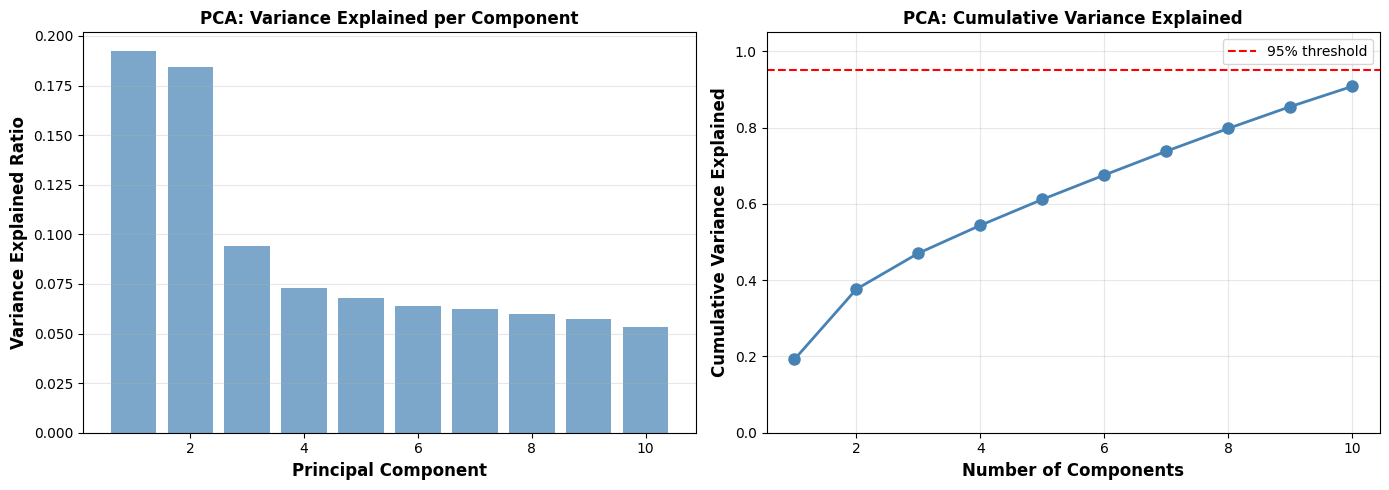

In [321]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Individual variance per component
ax = axes[0]
ax.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax.set_ylabel('Variance Explained Ratio', fontsize=12, fontweight='bold')
ax.set_title('PCA: Variance Explained per Component', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 2: Cumulative variance
ax = axes[1]
cumsum = np.cumsum(pca.explained_variance_ratio_)
ax.plot(range(1, n_components+1), cumsum, 'o-', linewidth=2, markersize=8, color='steelblue')
ax.axhline(y=0.95, color='red', linestyle='--', label='95% threshold')
ax.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax.set_title('PCA: Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [322]:
# Combine test data
X_test_combined = pd.concat([X_test_malware, X_test_ddos, X_test_intrusion], ignore_index=True)
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

# Preprocess test data (use the SAME preprocessor fitted on training data)
X_test_processed = preprocessor.transform(X_test_combined)

# Apply PCA (use the SAME PCA fitted on training data)
X_test_pca = pca.transform(X_test_processed)

print(f"Test data shape after preprocessing: {X_test_processed.shape}")
print(f"Test data shape after PCA: {X_test_pca.shape}")

# Also process individual test sets
X_test_malware_processed = preprocessor.transform(X_test_malware)
X_test_ddos_processed = preprocessor.transform(X_test_ddos)
X_test_intrusion_processed = preprocessor.transform(X_test_intrusion)

X_test_malware_pca = pca.transform(X_test_malware_processed)
X_test_ddos_pca = pca.transform(X_test_ddos_processed)
X_test_intrusion_pca = pca.transform(X_test_intrusion_processed)

print(f"\nIndividual test sets after PCA:")
print(f"  Malware test set: {X_test_malware_pca.shape}")
print(f"  DDoS test set: {X_test_ddos_pca.shape}")
print(f"  Intrusion test set: {X_test_intrusion_pca.shape}")

Test data shape after preprocessing: (960, 18)
Test data shape after PCA: (960, 10)

Individual test sets after PCA:
  Malware test set: (320, 10)
  DDoS test set: (320, 10)
  Intrusion test set: (320, 10)


In [323]:
print("\n" + "="*80)
print("PCA SUMMARY")
print("="*80)
print(f"✓ Original features: {X_train_processed.shape[1]}")
print(f"✓ PCA components: {X_train_pca.shape[1]}")
print(f"✓ Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"✓ Features reduced by: {X_train_processed.shape[1] - X_train_pca.shape[1]} dimensions")
print(f"✓ Training data ready: X_train_pca shape = {X_train_pca.shape}")
print(f"✓ Test data ready: X_test_pca shape = {X_test_pca.shape}")

print("\n✓ Data is ready for training SGD and MLP with PCA!")


PCA SUMMARY
✓ Original features: 18
✓ PCA components: 10
✓ Variance explained: 0.9082
✓ Features reduced by: 8 dimensions
✓ Training data ready: X_train_pca shape = (3840, 10)
✓ Test data ready: X_test_pca shape = (960, 10)

✓ Data is ready for training SGD and MLP with PCA!


### SGD with PCA

In [324]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [333]:
model_sgd_pca = SGDClassifier(
    warm_start=True,
    loss='log_loss',
    max_iter=1000,
    # learning_rate_init=0.01,  # You can adjust based on your tuning results
    random_state=42,
    verbose=0
)

print("✓ SGDClassifier created with:")
print(f"  - warm_start=True")
print(f"  - loss='log_loss'")
print(f"  - max_iter=500")
print(f"  - learning_rate_init=0.01")

✓ SGDClassifier created with:
  - warm_start=True
  - loss='log_loss'
  - max_iter=500
  - learning_rate_init=0.01


In [334]:
print("\n" + "="*80)
print("STEP 2: TRAIN SGD ON PCA FEATURES")
print("="*80)

print(f"\nTraining data shape: {X_train_pca.shape}")
print(f"Number of PCA components: {X_train_pca.shape[1]}")
print(f"Number of training samples: {X_train_pca.shape[0]}")

model_sgd_pca.fit(X_train_pca, y_train_combined)

print("✓ Training complete!")


STEP 2: TRAIN SGD ON PCA FEATURES

Training data shape: (3840, 10)
Number of PCA components: 10
Number of training samples: 3840
✓ Training complete!


In [335]:
print("\n" + "="*80)
print("STEP 3: EVALUATE ON TRAINING DATA")
print("="*80)

y_train_pred = model_sgd_pca.predict(X_train_pca)
train_accuracy = accuracy_score(y_train_combined, y_train_pred)
train_precision = precision_score(y_train_combined, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train_combined, y_train_pred, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_combined, y_train_pred, average='weighted', zero_division=0)

print(f"Training Metrics:")
print(f"  Accuracy:  {train_accuracy:.4f}")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")


STEP 3: EVALUATE ON TRAINING DATA
Training Metrics:
  Accuracy:  0.4260
  Precision: 0.4237
  Recall:    0.4260
  F1-Score:  0.4232


In [336]:
# Malware test set
y_pred_malware = model_sgd_pca.predict(X_test_malware_pca)
malware_accuracy = accuracy_score(y_test_malware, y_pred_malware)
malware_precision = precision_score(y_test_malware, y_pred_malware, average='weighted', zero_division=0)
malware_recall = recall_score(y_test_malware, y_pred_malware, average='weighted', zero_division=0)
malware_f1 = f1_score(y_test_malware, y_pred_malware, average='weighted', zero_division=0)

print(f"\nMalware Test Set:")
print(f"  Accuracy:  {malware_accuracy:.4f}")
print(f"  Precision: {malware_precision:.4f}")
print(f"  Recall:    {malware_recall:.4f}")
print(f"  F1-Score:  {malware_f1:.4f}")

# DDoS test set
y_pred_ddos = model_sgd_pca.predict(X_test_ddos_pca)
ddos_accuracy = accuracy_score(y_test_ddos, y_pred_ddos)
ddos_precision = precision_score(y_test_ddos, y_pred_ddos, average='weighted', zero_division=0)
ddos_recall = recall_score(y_test_ddos, y_pred_ddos, average='weighted', zero_division=0)
ddos_f1 = f1_score(y_test_ddos, y_pred_ddos, average='weighted', zero_division=0)

print(f"\nDDoS Test Set:")
print(f"  Accuracy:  {ddos_accuracy:.4f}")
print(f"  Precision: {ddos_precision:.4f}")
print(f"  Recall:    {ddos_recall:.4f}")
print(f"  F1-Score:  {ddos_f1:.4f}")

# Intrusion test set
y_pred_intrusion = model_sgd_pca.predict(X_test_intrusion_pca)
intrusion_accuracy = accuracy_score(y_test_intrusion, y_pred_intrusion)
intrusion_precision = precision_score(y_test_intrusion, y_pred_intrusion, average='weighted', zero_division=0)
intrusion_recall = recall_score(y_test_intrusion, y_pred_intrusion, average='weighted', zero_division=0)
intrusion_f1 = f1_score(y_test_intrusion, y_pred_intrusion, average='weighted', zero_division=0)

print(f"\nIntrusion Test Set:")
print(f"  Accuracy:  {intrusion_accuracy:.4f}")
print(f"  Precision: {intrusion_precision:.4f}")
print(f"  Recall:    {intrusion_recall:.4f}")
print(f"  F1-Score:  {intrusion_f1:.4f}")


Malware Test Set:
  Accuracy:  0.4281
  Precision: 1.0000
  Recall:    0.4281
  F1-Score:  0.5996

DDoS Test Set:
  Accuracy:  0.4813
  Precision: 1.0000
  Recall:    0.4813
  F1-Score:  0.6498

Intrusion Test Set:
  Accuracy:  0.2938
  Precision: 1.0000
  Recall:    0.2938
  F1-Score:  0.4541


In [337]:
# Combine all test predictions and labels
X_test_combined_pca = np.vstack([X_test_malware_pca, X_test_ddos_pca, X_test_intrusion_pca])
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

y_pred_combined = model_sgd_pca.predict(X_test_combined_pca)

combined_accuracy = accuracy_score(y_test_combined, y_pred_combined)
combined_precision = precision_score(y_test_combined, y_pred_combined, average='weighted', zero_division=0)
combined_recall = recall_score(y_test_combined, y_pred_combined, average='weighted', zero_division=0)
combined_f1 = f1_score(y_test_combined, y_pred_combined, average='weighted', zero_division=0)
macro_f1 = f1_score(y_test_combined, y_pred_combined, average='macro')

print(f"Combined Test Set (All 3 Attack Types):")
print(f"  Accuracy:        {combined_accuracy:.4f}")
print(f"  Precision:       {combined_precision:.4f}")
print(f"  Recall:          {combined_recall:.4f}")
print(f"  F1-Score:        {combined_f1:.4f}")
print(f"  Macro Avg F1:    {macro_f1:.4f}")

Combined Test Set (All 3 Attack Types):
  Accuracy:        0.4010
  Precision:       0.4003
  Recall:          0.4010
  F1-Score:        0.3974
  Macro Avg F1:    0.3974


In [338]:
print("\n" + classification_report(y_test_combined, y_pred_combined, 
                                   target_names=le.classes_))


              precision    recall  f1-score   support

        DDoS       0.39      0.48      0.43       320
   Intrusion       0.38      0.29      0.33       320
     Malware       0.43      0.43      0.43       320

    accuracy                           0.40       960
   macro avg       0.40      0.40      0.40       960
weighted avg       0.40      0.40      0.40       960



In [339]:
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1],
    'Malware': [malware_accuracy, malware_precision, malware_recall, malware_f1],
    'DDoS': [ddos_accuracy, ddos_precision, ddos_recall, ddos_f1],
    'Intrusion': [intrusion_accuracy, intrusion_precision, intrusion_recall, intrusion_f1],
    'Combined': [combined_accuracy, combined_precision, combined_recall, combined_f1]
}

summary_df = pd.DataFrame(summary_data)
summary_df

,Metric,Training,Malware,DDoS,Intrusion,Combined
0,Accuracy,0.426042,0.428125,0.481250,0.293750,0.401042
1,Precision,0.423736,1.000000,1.000000,1.000000,0.400265
2,Recall,0.426042,0.428125,0.481250,0.293750,0.401042
3,F1-Score,0.423211,0.599562,0.649789,0.454106,0.397363


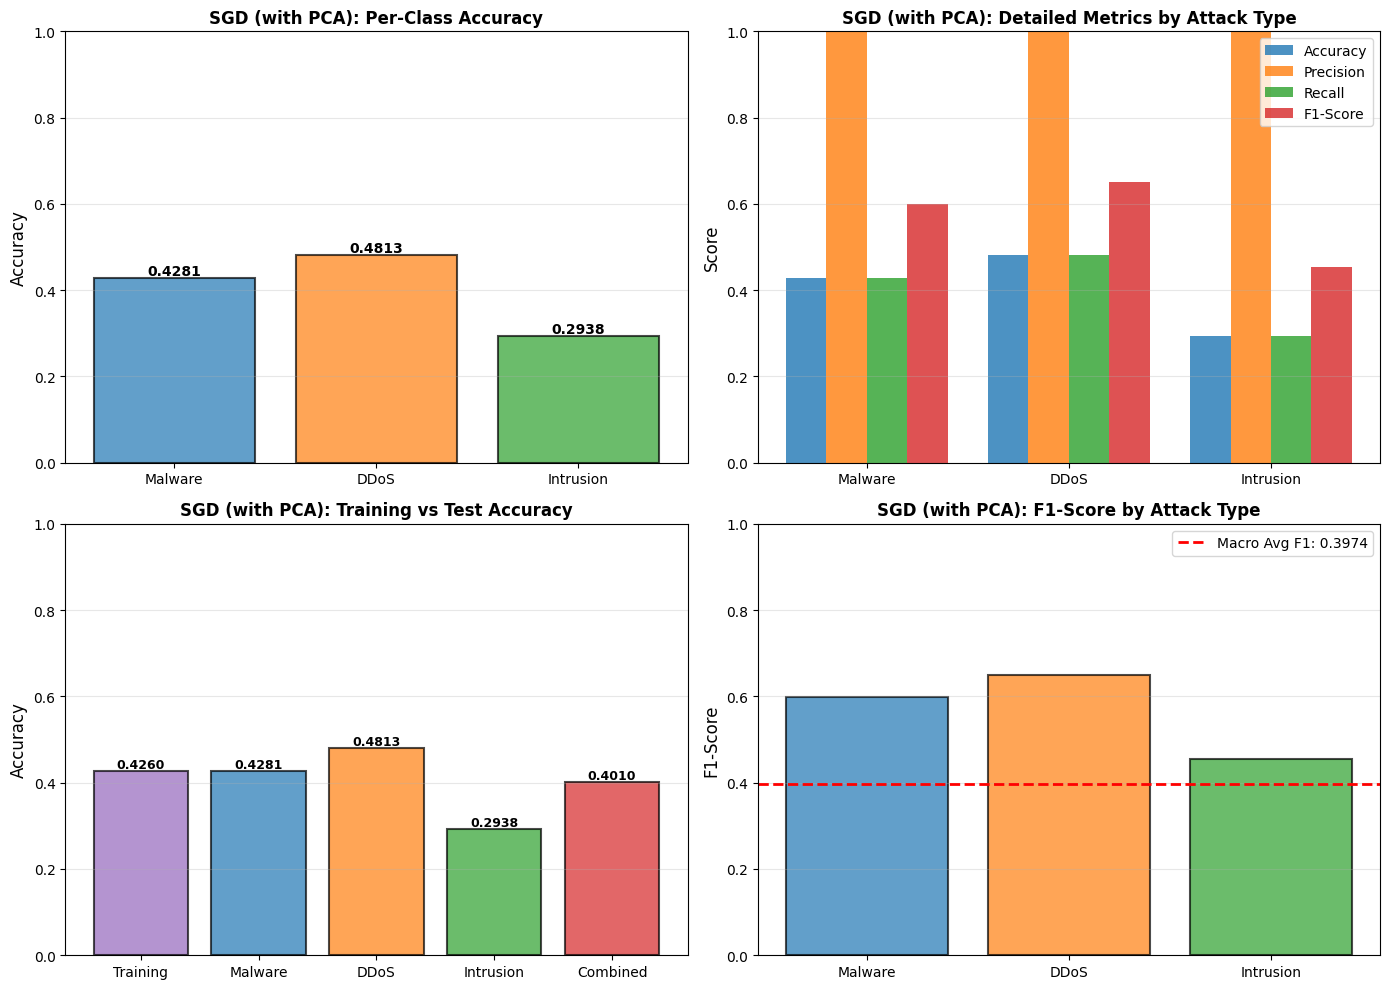

In [340]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Per-class Accuracy
ax = axes[0, 0]
attacks = ['Malware', 'DDoS', 'Intrusion']
accuracies = [malware_accuracy, ddos_accuracy, intrusion_accuracy]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.bar(attacks, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('SGD (with PCA): Per-Class Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Metrics Comparison
ax = axes[0, 1]
x = np.arange(len(attacks))
width = 0.2
ax.bar(x - width*1.5, [malware_accuracy, ddos_accuracy, intrusion_accuracy], width, label='Accuracy', alpha=0.8)
ax.bar(x - width/2, [malware_precision, ddos_precision, intrusion_precision], width, label='Precision', alpha=0.8)
ax.bar(x + width/2, [malware_recall, ddos_recall, intrusion_recall], width, label='Recall', alpha=0.8)
ax.bar(x + width*1.5, [malware_f1, ddos_f1, intrusion_f1], width, label='F1-Score', alpha=0.8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('SGD (with PCA): Detailed Metrics by Attack Type', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Plot 3: Training vs Test Accuracy
ax = axes[1, 0]
datasets = ['Training', 'Malware', 'DDoS', 'Intrusion', 'Combined']
test_accs = [train_accuracy, malware_accuracy, ddos_accuracy, intrusion_accuracy, combined_accuracy]
colors_2 = ['#9467bd', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(datasets, test_accs, color=colors_2, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('SGD (with PCA): Training vs Test Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: F1-Score Comparison
ax = axes[1, 1]
ax.bar(attacks, [malware_f1, ddos_f1, intrusion_f1], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=macro_f1, color='red', linestyle='--', linewidth=2, label=f'Macro Avg F1: {macro_f1:.4f}')
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('SGD (with PCA): F1-Score by Attack Type', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [341]:
print("\n" + "="*80)
print("SGD WITH PCA - SUMMARY")
print("="*80)
print(f"✓ Model trained on {X_train_pca.shape[1]} PCA components")
print(f"✓ Training samples: {X_train_pca.shape[0]}")
print(f"✓ Training accuracy: {train_accuracy:.4f}")
print(f"✓ Combined test accuracy: {combined_accuracy:.4f}")
print(f"✓ Macro F1 score: {macro_f1:.4f}")
print(f"\nPer-class test accuracy:")
print(f"  - Malware:    {malware_accuracy:.4f}")
print(f"  - DDoS:       {ddos_accuracy:.4f}")
print(f"  - Intrusion:  {intrusion_accuracy:.4f}")
print("="*80)


SGD WITH PCA - SUMMARY
✓ Model trained on 10 PCA components
✓ Training samples: 3840
✓ Training accuracy: 0.4260
✓ Combined test accuracy: 0.4010
✓ Macro F1 score: 0.3974

Per-class test accuracy:
  - Malware:    0.4281
  - DDoS:       0.4813
  - Intrusion:  0.2938


### MLP with PCA

In [342]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [372]:
model_mlp_pca = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,  # You can adjust based on your tuning results
    max_iter=1000,              # You can adjust based on your tuning results
    warm_start=True,
    # early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=0
)

In [373]:
model_mlp_pca.fit(X_train_pca, y_train_combined)

print("✓ Training complete!")
print(f"  - Iterations trained: {model_mlp_pca.n_iter_}")
print(f"  - Final loss: {model_mlp_pca.loss_:.6f}")


✓ Training complete!
  - Iterations trained: 651
  - Final loss: 0.333936


In [374]:
y_train_pred = model_mlp_pca.predict(X_train_pca)
train_accuracy = accuracy_score(y_train_combined, y_train_pred)
train_precision = precision_score(y_train_combined, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train_combined, y_train_pred, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_combined, y_train_pred, average='weighted', zero_division=0)


In [375]:
print(f"Training Metrics:")
print(f"  Accuracy:  {train_accuracy:.4f}")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")


Training Metrics:
  Accuracy:  0.8794
  Precision: 0.8798
  Recall:    0.8794
  F1-Score:  0.8788


In [376]:
# Malware test set
y_pred_malware = model_mlp_pca.predict(X_test_malware_pca)
malware_accuracy = accuracy_score(y_test_malware, y_pred_malware)
malware_precision = precision_score(y_test_malware, y_pred_malware, average='weighted', zero_division=0)
malware_recall = recall_score(y_test_malware, y_pred_malware, average='weighted', zero_division=0)
malware_f1 = f1_score(y_test_malware, y_pred_malware, average='weighted', zero_division=0)

print(f"\nMalware Test Set:")
print(f"  Accuracy:  {malware_accuracy:.4f}")
print(f"  Precision: {malware_precision:.4f}")
print(f"  Recall:    {malware_recall:.4f}")
print(f"  F1-Score:  {malware_f1:.4f}")

# DDoS test set
y_pred_ddos = model_mlp_pca.predict(X_test_ddos_pca)
ddos_accuracy = accuracy_score(y_test_ddos, y_pred_ddos)
ddos_precision = precision_score(y_test_ddos, y_pred_ddos, average='weighted', zero_division=0)
ddos_recall = recall_score(y_test_ddos, y_pred_ddos, average='weighted', zero_division=0)
ddos_f1 = f1_score(y_test_ddos, y_pred_ddos, average='weighted', zero_division=0)

print(f"\nDDoS Test Set:")
print(f"  Accuracy:  {ddos_accuracy:.4f}")
print(f"  Precision: {ddos_precision:.4f}")
print(f"  Recall:    {ddos_recall:.4f}")
print(f"  F1-Score:  {ddos_f1:.4f}")

# Intrusion test set
y_pred_intrusion = model_mlp_pca.predict(X_test_intrusion_pca)
intrusion_accuracy = accuracy_score(y_test_intrusion, y_pred_intrusion)
intrusion_precision = precision_score(y_test_intrusion, y_pred_intrusion, average='weighted', zero_division=0)
intrusion_recall = recall_score(y_test_intrusion, y_pred_intrusion, average='weighted', zero_division=0)
intrusion_f1 = f1_score(y_test_intrusion, y_pred_intrusion, average='weighted', zero_division=0)

print(f"\nIntrusion Test Set:")
print(f"  Accuracy:  {intrusion_accuracy:.4f}")
print(f"  Precision: {intrusion_precision:.4f}")
print(f"  Recall:    {intrusion_recall:.4f}")
print(f"  F1-Score:  {intrusion_f1:.4f}")



Malware Test Set:
  Accuracy:  0.7469
  Precision: 1.0000
  Recall:    0.7469
  F1-Score:  0.8551

DDoS Test Set:
  Accuracy:  0.7063
  Precision: 1.0000
  Recall:    0.7063
  F1-Score:  0.8278

Intrusion Test Set:
  Accuracy:  0.5875
  Precision: 1.0000
  Recall:    0.5875
  F1-Score:  0.7402


In [377]:
# Combine all test predictions and labels
X_test_combined_pca = np.vstack([X_test_malware_pca, X_test_ddos_pca, X_test_intrusion_pca])
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

y_pred_combined = model_mlp_pca.predict(X_test_combined_pca)

combined_accuracy = accuracy_score(y_test_combined, y_pred_combined)
combined_precision = precision_score(y_test_combined, y_pred_combined, average='weighted', zero_division=0)
combined_recall = recall_score(y_test_combined, y_pred_combined, average='weighted', zero_division=0)
combined_f1 = f1_score(y_test_combined, y_pred_combined, average='weighted', zero_division=0)
macro_f1 = f1_score(y_test_combined, y_pred_combined, average='macro')

print(f"Combined Test Set (All 3 Attack Types):")
print(f"  Accuracy:        {combined_accuracy:.4f}")
print(f"  Precision:       {combined_precision:.4f}")
print(f"  Recall:          {combined_recall:.4f}")
print(f"  F1-Score:        {combined_f1:.4f}")
print(f"  Macro Avg F1:    {macro_f1:.4f}")

Combined Test Set (All 3 Attack Types):
  Accuracy:        0.6802
  Precision:       0.6787
  Recall:          0.6802
  F1-Score:        0.6787
  Macro Avg F1:    0.6787


In [378]:
print("\n" + classification_report(y_test_combined, y_pred_combined, 
                                   target_names=le.classes_))


              precision    recall  f1-score   support

        DDoS       0.69      0.71      0.70       320
   Intrusion       0.65      0.59      0.62       320
     Malware       0.70      0.75      0.72       320

    accuracy                           0.68       960
   macro avg       0.68      0.68      0.68       960
weighted avg       0.68      0.68      0.68       960



In [379]:
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1],
    'Malware': [malware_accuracy, malware_precision, malware_recall, malware_f1],
    'DDoS': [ddos_accuracy, ddos_precision, ddos_recall, ddos_f1],
    'Intrusion': [intrusion_accuracy, intrusion_precision, intrusion_recall, intrusion_f1],
    'Combined': [combined_accuracy, combined_precision, combined_recall, combined_f1]
}

summary_df_mlp_pca = pd.DataFrame(summary_data)
summary_df_mlp_pca 

,Metric,Training,Malware,DDoS,Intrusion,Combined
0,Accuracy,0.879427,0.746875,0.706250,0.587500,0.680208
1,Precision,0.879750,1.000000,1.000000,1.000000,0.678710
2,Recall,0.879427,0.746875,0.706250,0.587500,0.680208
3,F1-Score,0.878799,0.855098,0.827839,0.740157,0.678660


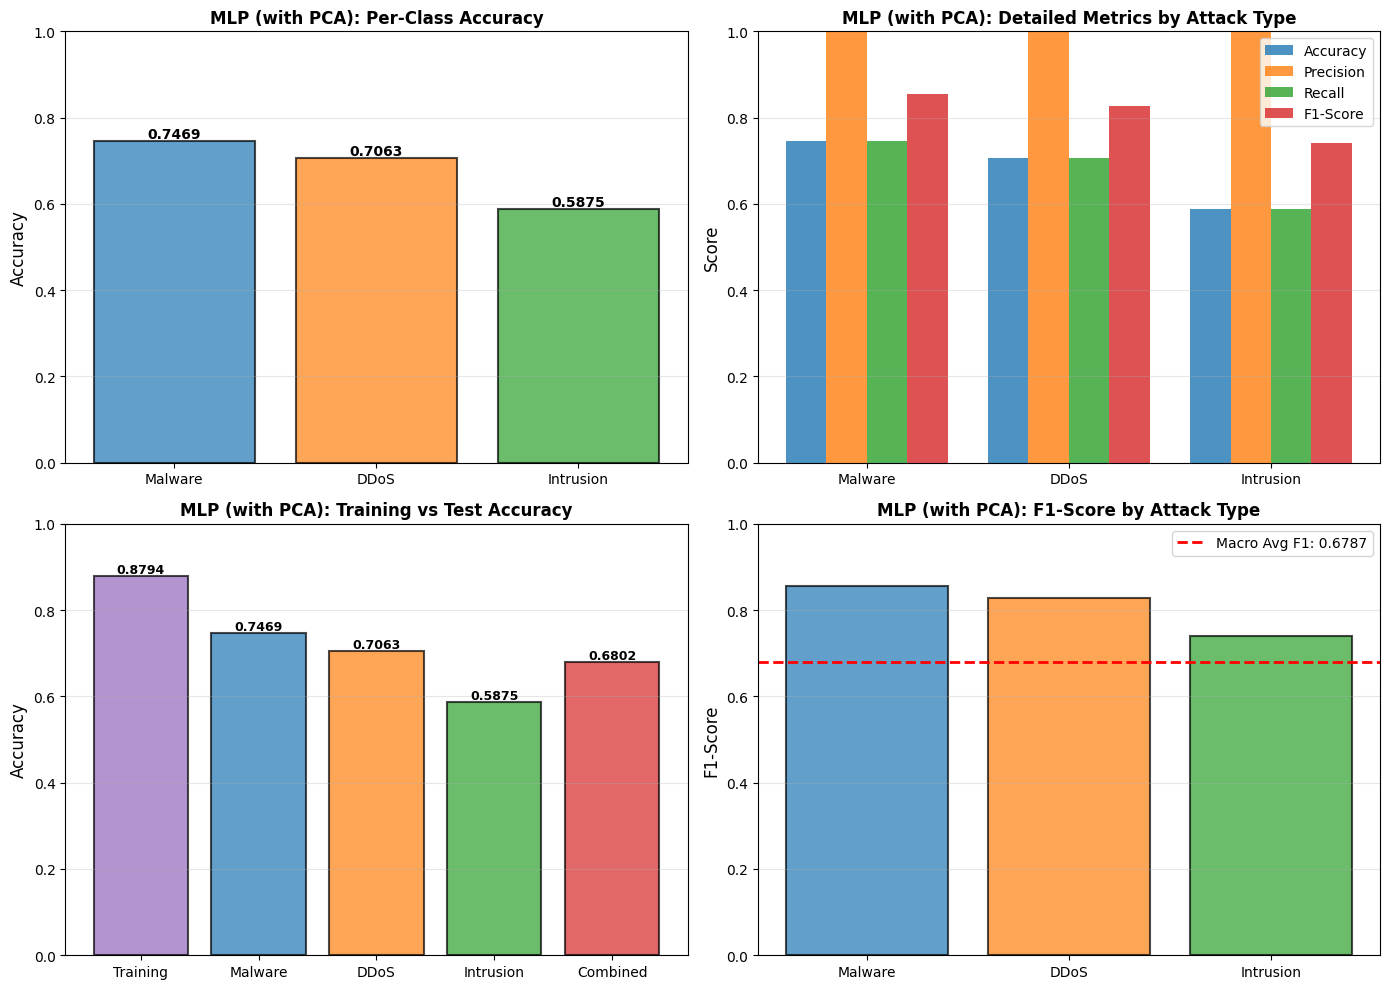

In [380]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Per-class Accuracy
ax = axes[0, 0]
attacks = ['Malware', 'DDoS', 'Intrusion']
accuracies = [malware_accuracy, ddos_accuracy, intrusion_accuracy]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.bar(attacks, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('MLP (with PCA): Per-Class Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Metrics Comparison
ax = axes[0, 1]
x = np.arange(len(attacks))
width = 0.2
ax.bar(x - width*1.5, [malware_accuracy, ddos_accuracy, intrusion_accuracy], width, label='Accuracy', alpha=0.8)
ax.bar(x - width/2, [malware_precision, ddos_precision, intrusion_precision], width, label='Precision', alpha=0.8)
ax.bar(x + width/2, [malware_recall, ddos_recall, intrusion_recall], width, label='Recall', alpha=0.8)
ax.bar(x + width*1.5, [malware_f1, ddos_f1, intrusion_f1], width, label='F1-Score', alpha=0.8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('MLP (with PCA): Detailed Metrics by Attack Type', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Plot 3: Training vs Test Accuracy
ax = axes[1, 0]
datasets = ['Training', 'Malware', 'DDoS', 'Intrusion', 'Combined']
test_accs = [train_accuracy, malware_accuracy, ddos_accuracy, intrusion_accuracy, combined_accuracy]
colors_2 = ['#9467bd', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(datasets, test_accs, color=colors_2, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('MLP (with PCA): Training vs Test Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: F1-Score Comparison
ax = axes[1, 1]
ax.bar(attacks, [malware_f1, ddos_f1, intrusion_f1], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=macro_f1, color='red', linestyle='--', linewidth=2, label=f'Macro Avg F1: {macro_f1:.4f}')
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('MLP (with PCA): F1-Score by Attack Type', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### hyperparameter with pca and mlp

MLP HYPERPARAMETER TUNING WITH PCA

STEP 1: DEFINE PARAMETER RANGES TO TEST

Learning rates to test: [0.0001, 0.0005, 0.001, 0.005, 0.01]
Max iterations to test: [300, 500, 700, 1000, 5000, 10000]
Total combinations: 30
Training data shape: (3840, 10)
Number of PCA components: 10

STEP 2: TRAIN AND TEST ALL COMBINATIONS

[1/30] Testing: lr=0.0001, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7661
  Combined Test Accuracy: 0.6583
  Training Time: 2.48s

[2/30] Testing: lr=0.0001, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.8161
  Combined Test Accuracy: 0.6979
  Training Time: 3.76s

[3/30] Testing: lr=0.0001, max_iter=700


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.8427
  Combined Test Accuracy: 0.6646
  Training Time: 5.17s

[4/30] Testing: lr=0.0001, max_iter=1000


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.8940
  Combined Test Accuracy: 0.7156
  Training Time: 7.39s

[5/30] Testing: lr=0.0001, max_iter=5000
  Train Accuracy: 0.9357
  Combined Test Accuracy: 0.7010
  Training Time: 11.97s

[6/30] Testing: lr=0.0001, max_iter=10000
  Train Accuracy: 0.9518
  Combined Test Accuracy: 0.7021
  Training Time: 12.85s

[7/30] Testing: lr=0.0005, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.9193
  Combined Test Accuracy: 0.6979
  Training Time: 2.21s

[8/30] Testing: lr=0.0005, max_iter=500
  Train Accuracy: 0.9359
  Combined Test Accuracy: 0.6906
  Training Time: 3.21s

[9/30] Testing: lr=0.0005, max_iter=700
  Train Accuracy: 0.9510
  Combined Test Accuracy: 0.7052
  Training Time: 3.29s

[10/30] Testing: lr=0.0005, max_iter=1000
  Train Accuracy: 0.9122
  Combined Test Accuracy: 0.7094
  Training Time: 2.33s

[11/30] Testing: lr=0.0005, max_iter=5000
  Train Accuracy: 0.9258
  Combined Test Accuracy: 0.7167
  Training Time: 2.16s

[12/30] Testing: lr=0.0005, max_iter=10000
  Train Accuracy: 0.9435
  Combined Test Accuracy: 0.7167
  Training Time: 3.23s

[13/30] Testing: lr=0.001, max_iter=300
  Train Accuracy: 0.9367
  Combined Test Accuracy: 0.6854
  Training Time: 1.91s

[14/30] Testing: lr=0.001, max_iter=500
  Train Accuracy: 0.9424
  Combined Test Accuracy: 0.7146
  Training Time: 2.19s

[15/30] Testing: lr=0.001, max_iter=700
  Train Accuracy:

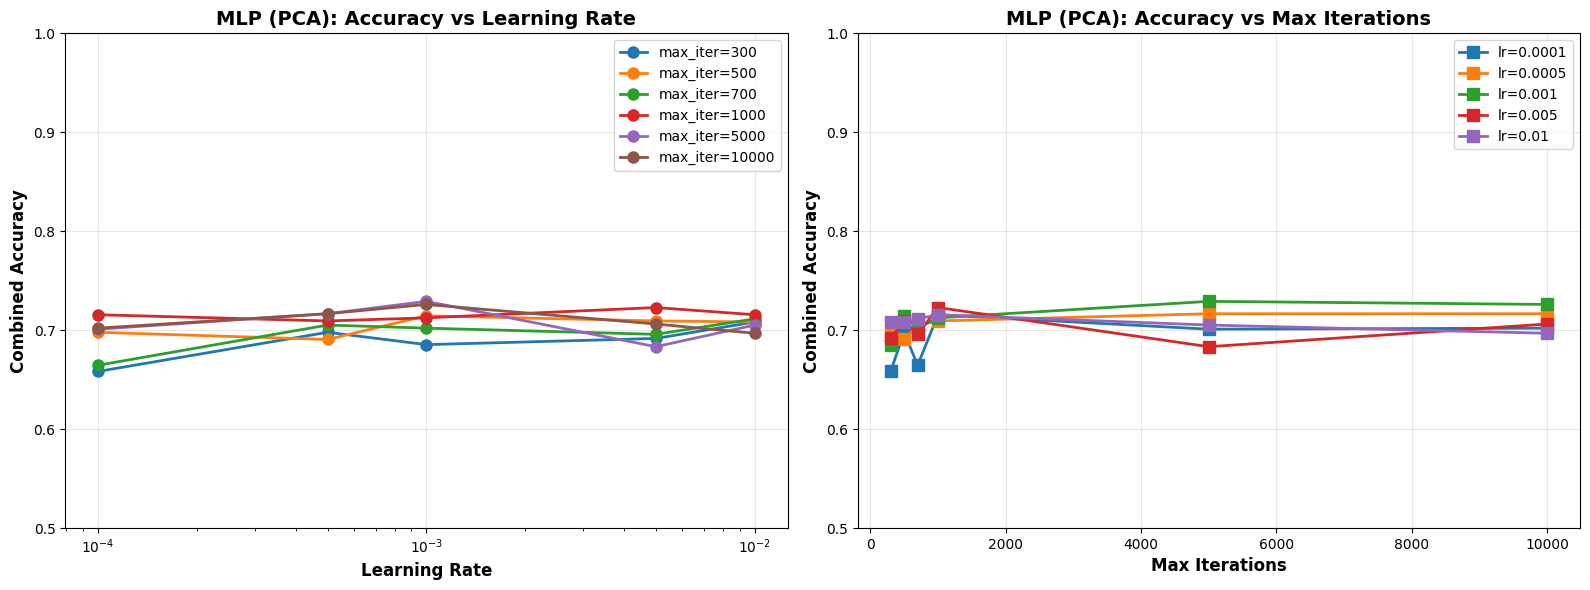


Generating heatmap...


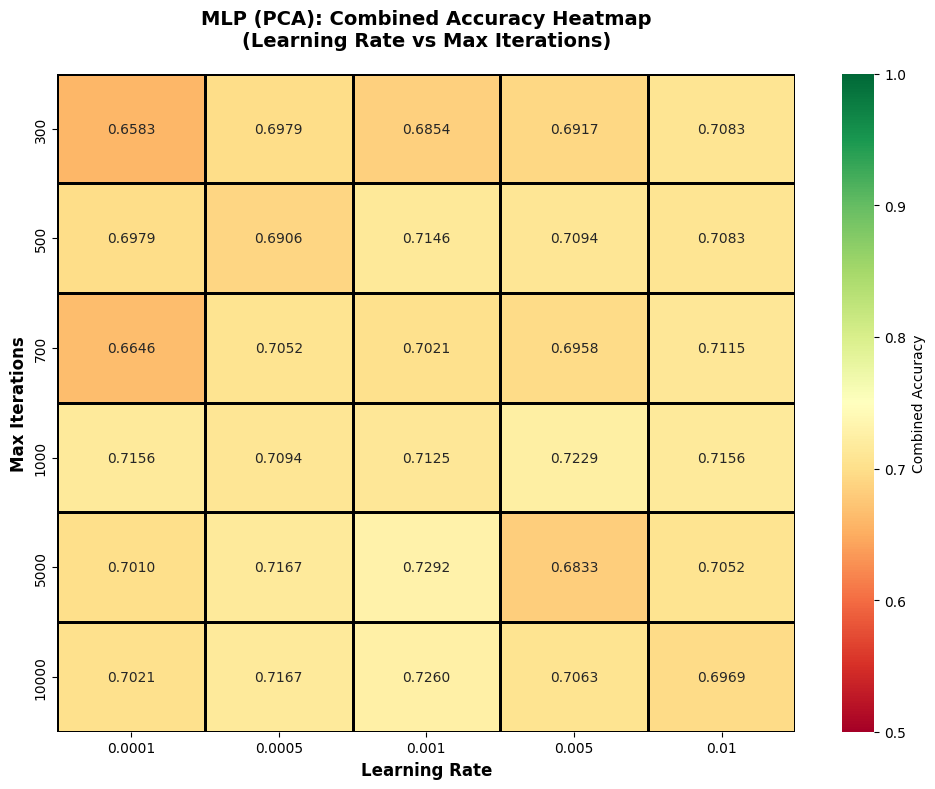

Generating per-class accuracy heatmaps...


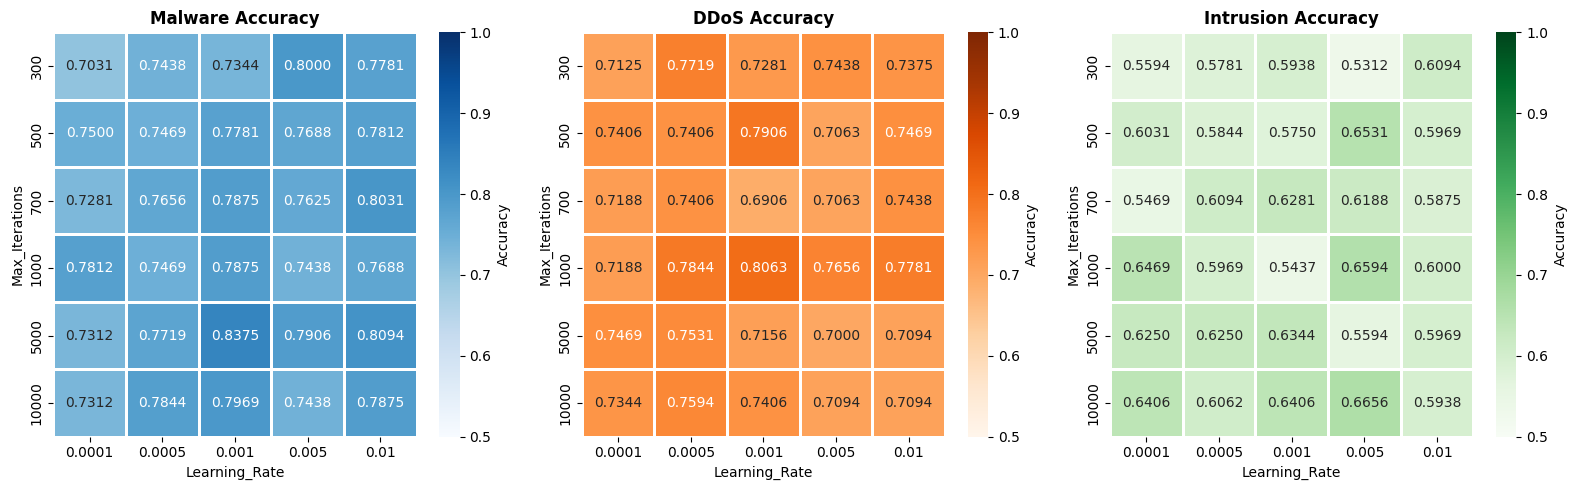


STEP 6: SUMMARY TABLE

 Learning_Rate  Max_Iterations  Train_Accuracy  Malware_Accuracy  DDoS_Accuracy  Intrusion_Accuracy  Combined_Accuracy  Macro_F1  Training_Time
        0.0001             300        0.766146          0.703125       0.712500            0.559375           0.658333  0.657061       2.476863
        0.0001             500        0.816146          0.750000       0.740625            0.603125           0.697917  0.696644       3.758263
        0.0001             700        0.842708          0.728125       0.718750            0.546875           0.664583  0.662659       5.174608
        0.0001            1000        0.894010          0.781250       0.718750            0.646875           0.715625  0.715047       7.388392
        0.0001            5000        0.935677          0.731250       0.746875            0.625000           0.701042  0.700537      11.970667
        0.0001           10000        0.951823          0.731250       0.734375            0.640625           0.

In [ ]:
"""
MLP HYPERPARAMETER TUNING WITH PCA
Test different learning rates and max iterations to find the best combination
for MLP using PCA-reduced features
"""

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("MLP HYPERPARAMETER TUNING WITH PCA")
print("="*80)

# ===== ASSUMPTION =====
# You have already completed PCA and have:
# - X_train_pca (training data with PCA components)
# - y_train_combined (training labels)
# - X_test_malware_pca, X_test_ddos_pca, X_test_intrusion_pca
# - y_test_malware, y_test_ddos, y_test_intrusion

# ===== DEFINE PARAMETER RANGES =====
print("\n" + "="*80)
print("STEP 1: DEFINE PARAMETER RANGES TO TEST")
print("="*80)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
max_iterations = [300, 500, 700, 1000, 5000, 10000]

print(f"\nLearning rates to test: {learning_rates}")
print(f"Max iterations to test: {max_iterations}")
print(f"Total combinations: {len(learning_rates) * len(max_iterations)}")
print(f"Training data shape: {X_train_pca.shape}")
print(f"Number of PCA components: {X_train_pca.shape[1]}")

# ===== TEST ALL COMBINATIONS =====
print("\n" + "="*80)
print("STEP 2: TRAIN AND TEST ALL COMBINATIONS")
print("="*80)

results = []
total_tests = len(learning_rates) * len(max_iterations)
current_test = 0

for lr in learning_rates:
    for max_iter in max_iterations:
        current_test += 1
        print(f"\n[{current_test}/{total_tests}] Testing: lr={lr}, max_iter={max_iter}")
        
        # Create MLP model
        mlp_model = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            learning_rate_init=lr,
            max_iter=max_iter,
            # early_stopping=True,
            # validation_fraction=0.1,
            # n_iter_no_change=10,
            # random_state=42,
            verbose=0
        )
        
        # Train model
        start_time = time.time()
        mlp_model.fit(X_train_pca, y_train_combined)
        training_time = time.time() - start_time
        
        # Make predictions on training data
        y_train_pred = mlp_model.predict(X_train_pca)
        train_accuracy = accuracy_score(y_train_combined, y_train_pred)
        
        # Make predictions on test data (individual attack types)
        y_pred_malware = mlp_model.predict(X_test_malware_pca)
        y_pred_ddos = mlp_model.predict(X_test_ddos_pca)
        y_pred_intrusion = mlp_model.predict(X_test_intrusion_pca)
        
        # Calculate accuracy for each attack type
        malware_accuracy = accuracy_score(y_test_malware, y_pred_malware)
        ddos_accuracy = accuracy_score(y_test_ddos, y_pred_ddos)
        intrusion_accuracy = accuracy_score(y_test_intrusion, y_pred_intrusion)
        
        # Combine all test predictions and labels
        y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
        y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
        
        # Calculate combined accuracy and F1 score
        combined_accuracy = accuracy_score(y_test_all, y_pred_all)
        macro_f1 = f1_score(y_test_all, y_pred_all, average='macro')
        
        # Print results for this combination
        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Combined Test Accuracy: {combined_accuracy:.4f}")
        print(f"  Training Time: {training_time:.2f}s")
        
        # Store results
        results.append({
            'Learning_Rate': lr,
            'Max_Iterations': max_iter,
            'Training_Time': training_time,
            'Train_Accuracy': train_accuracy,
            'Malware_Accuracy': malware_accuracy,
            'DDoS_Accuracy': ddos_accuracy,
            'Intrusion_Accuracy': intrusion_accuracy,
            'Combined_Accuracy': combined_accuracy,
            'Macro_F1': macro_f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# ===== FIND BEST CONFIGURATION =====
print("\n" + "="*80)
print("STEP 3: FIND BEST CONFIGURATION")
print("="*80)

best_idx = results_df['Combined_Accuracy'].idxmax()
best_config = results_df.loc[best_idx]

print(f"\n✓ BEST CONFIGURATION FOUND:")
print(f"  Learning Rate: {best_config['Learning_Rate']}")
print(f"  Max Iterations: {int(best_config['Max_Iterations'])}")
print(f"  Combined Test Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Training Time: {best_config['Training_Time']:.2f}s")
print(f"\n  Per-class Accuracy:")
print(f"    - Malware:    {best_config['Malware_Accuracy']:.4f}")
print(f"    - DDoS:       {best_config['DDoS_Accuracy']:.4f}")
print(f"    - Intrusion:  {best_config['Intrusion_Accuracy']:.4f}")
print(f"    - Macro F1:   {best_config['Macro_F1']:.4f}")

# ===== TOP 5 CONFIGURATIONS =====
print("\n" + "="*80)
print("STEP 4: TOP 5 CONFIGURATIONS")
print("="*80)

top_5 = results_df.nlargest(5, 'Combined_Accuracy')
print("\n" + top_5[['Learning_Rate', 'Max_Iterations', 'Combined_Accuracy', 
                     'Training_Time']].to_string(index=False))

# ===== VISUALIZATION 1: LINE PLOTS =====
print("\n" + "="*80)
print("STEP 5: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy vs Learning Rate
ax = axes[0]
for max_iter in max_iterations:
    subset = results_df[results_df['Max_Iterations'] == max_iter]
    ax.plot(subset['Learning_Rate'], subset['Combined_Accuracy'], 
            marker='o', label=f'max_iter={max_iter}', linewidth=2, markersize=8)

ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP (PCA): Accuracy vs Learning Rate', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_ylim([0.5, 1.0])

# Plot 2: Accuracy vs Max Iterations
ax = axes[1]
for lr in learning_rates:
    subset = results_df[results_df['Learning_Rate'] == lr]
    ax.plot(subset['Max_Iterations'], subset['Combined_Accuracy'], 
            marker='s', label=f'lr={lr}', linewidth=2, markersize=8)

ax.set_xlabel('Max Iterations', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP (PCA): Accuracy vs Max Iterations', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# ===== VISUALIZATION 2: HEATMAP =====
print("\nGenerating heatmap...")

# Create pivot table
heatmap_data = results_df.pivot_table(
    values='Combined_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Combined Accuracy'}, 
            vmin=0.5, vmax=1.0, linewidths=1, linecolor='black')

plt.title('MLP (PCA): Combined Accuracy Heatmap\n(Learning Rate vs Max Iterations)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Max Iterations', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 3: PER-CLASS ACCURACY HEATMAPS =====
print("Generating per-class accuracy heatmaps...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Malware accuracy
ax = axes[0]
malware_pivot = results_df.pivot_table(
    values='Malware_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(malware_pivot, annot=True, fmt='.4f', cmap='Blues', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Malware Accuracy', fontsize=12, fontweight='bold')

# DDoS accuracy
ax = axes[1]
ddos_pivot = results_df.pivot_table(
    values='DDoS_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(ddos_pivot, annot=True, fmt='.4f', cmap='Oranges', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('DDoS Accuracy', fontsize=12, fontweight='bold')

# Intrusion accuracy
ax = axes[2]
intrusion_pivot = results_df.pivot_table(
    values='Intrusion_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(intrusion_pivot, annot=True, fmt='.4f', cmap='Greens', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Intrusion Accuracy', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ===== SUMMARY TABLE =====
print("\n" + "="*80)
print("STEP 6: SUMMARY TABLE")
print("="*80)

summary_df = results_df[['Learning_Rate', 'Max_Iterations', 'Train_Accuracy',
                          'Malware_Accuracy', 'DDoS_Accuracy', 'Intrusion_Accuracy',
                          'Combined_Accuracy', 'Macro_F1', 'Training_Time']].copy()

print("\n" + summary_df.to_string(index=False))

# ===== RECOMMENDATIONS =====
print("\n" + "="*80)
print("STEP 7: RECOMMENDATIONS")
print("="*80)

print(f"\n✓ USE THESE PARAMETERS FOR BEST ACCURACY (WITH PCA):")
print(f"  model = MLPClassifier(")
print(f"      hidden_layer_sizes=(128, 64, 32),")
print(f"      activation='relu',")
print(f"      solver='adam',")
print(f"      learning_rate_init={best_config['Learning_Rate']},")
print(f"      max_iter={int(best_config['Max_Iterations'])},")
print(f"      early_stopping=True,")
print(f"      validation_fraction=0.1,")
print(f"      n_iter_no_change=10,")
print(f"      random_state=42")
print(f"  )")
print(f"\nExpected Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"Training Time: {best_config['Training_Time']:.2f}s")

# ===== COMPARISON WITH FEATURE SELECTION =====
print("\n" + "="*80)
print("STEP 8: QUICK COMPARISON")
print("="*80)

print(f"\nBest accuracy achieved with PCA and these parameters:")
print(f"  Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Malware: {best_config['Malware_Accuracy']:.4f}")
print(f"  DDoS: {best_config['DDoS_Accuracy']:.4f}")
print(f"  Intrusion: {best_config['Intrusion_Accuracy']:.4f}")

print("\n✓ Now you can compare this with Feature Selection results!")

print("\n" + "="*80)
print("✓ HYPERPARAMETER TUNING COMPLETE!")
print("="*80)

MLP HYPERPARAMETER TUNING WITH PCA

STEP 1: DEFINE PARAMETER RANGES TO TEST

Learning rates to test: [0.0001, 0.0005, 0.001, 0.005, 0.01]
Max iterations to test: [300, 500, 700, 1000, 5000, 10000]
Total combinations: 30
Training data shape: (3840, 10)
Number of PCA components: 10

STEP 2: TRAIN AND TEST ALL COMBINATIONS

[1/30] Testing: lr=0.0001, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.6388
  Combined Test Accuracy: 0.5958
  Training Time: 1.23s

[2/30] Testing: lr=0.0001, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.6836
  Combined Test Accuracy: 0.6167
  Training Time: 2.31s

[3/30] Testing: lr=0.0001, max_iter=700


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7078
  Combined Test Accuracy: 0.6385
  Training Time: 2.76s

[4/30] Testing: lr=0.0001, max_iter=1000


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7438
  Combined Test Accuracy: 0.6521
  Training Time: 4.03s

[5/30] Testing: lr=0.0001, max_iter=5000
  Train Accuracy: 0.8333
  Combined Test Accuracy: 0.6667
  Training Time: 13.65s

[6/30] Testing: lr=0.0001, max_iter=10000
  Train Accuracy: 0.8208
  Combined Test Accuracy: 0.6854
  Training Time: 11.52s

[7/30] Testing: lr=0.0005, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7729
  Combined Test Accuracy: 0.6552
  Training Time: 1.16s

[8/30] Testing: lr=0.0005, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7987
  Combined Test Accuracy: 0.6646
  Training Time: 1.90s

[9/30] Testing: lr=0.0005, max_iter=700


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.8344
  Combined Test Accuracy: 0.6729
  Training Time: 2.78s

[10/30] Testing: lr=0.0005, max_iter=1000
  Train Accuracy: 0.8510
  Combined Test Accuracy: 0.7104
  Training Time: 3.17s

[11/30] Testing: lr=0.0005, max_iter=5000
  Train Accuracy: 0.8648
  Combined Test Accuracy: 0.6917
  Training Time: 4.43s

[12/30] Testing: lr=0.0005, max_iter=10000
  Train Accuracy: 0.8438
  Combined Test Accuracy: 0.6875
  Training Time: 3.41s

[13/30] Testing: lr=0.001, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.8221
  Combined Test Accuracy: 0.6875
  Training Time: 3.27s

[14/30] Testing: lr=0.001, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.8513
  Combined Test Accuracy: 0.6771
  Training Time: 2.40s

[15/30] Testing: lr=0.001, max_iter=700
  Train Accuracy: 0.8812
  Combined Test Accuracy: 0.7344
  Training Time: 2.46s

[16/30] Testing: lr=0.001, max_iter=1000
  Train Accuracy: 0.8716
  Combined Test Accuracy: 0.6896
  Training Time: 2.50s

[17/30] Testing: lr=0.001, max_iter=5000
  Train Accuracy: 0.8695
  Combined Test Accuracy: 0.6823
  Training Time: 2.36s

[18/30] Testing: lr=0.001, max_iter=10000
  Train Accuracy: 0.8591
  Combined Test Accuracy: 0.6885
  Training Time: 1.98s

[19/30] Testing: lr=0.005, max_iter=300
  Train Accuracy: 0.8716
  Combined Test Accuracy: 0.6813
  Training Time: 0.67s

[20/30] Testing: lr=0.005, max_iter=500
  Train Accuracy: 0.8938
  Combined Test Accuracy: 0.6823
  Training Time: 1.00s

[21/30] Testing: lr=0.005, max_iter=700
  Train Accuracy: 0.8831
  Combined Test Accuracy: 0.6750
  Training Time: 0.85s

[22/30] Testing: lr=0.005, max_iter=1000
  Train Accuracy: 0

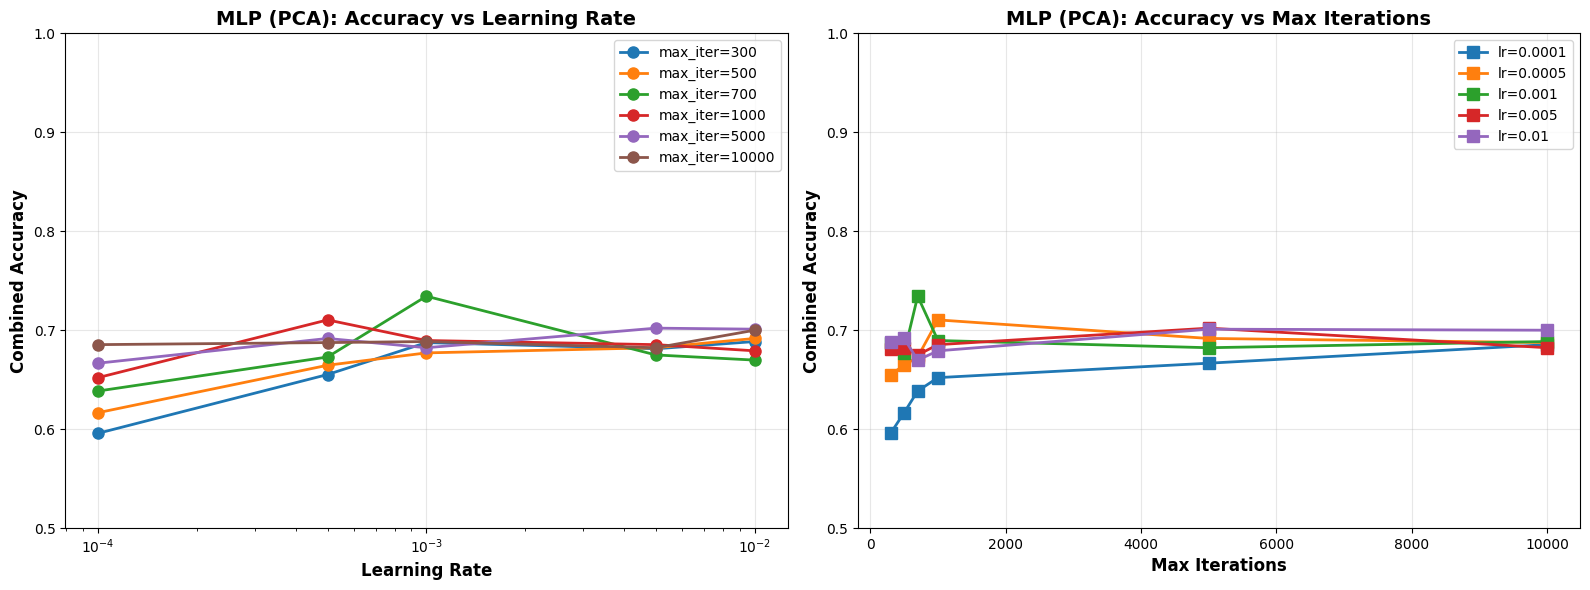


Generating heatmap...


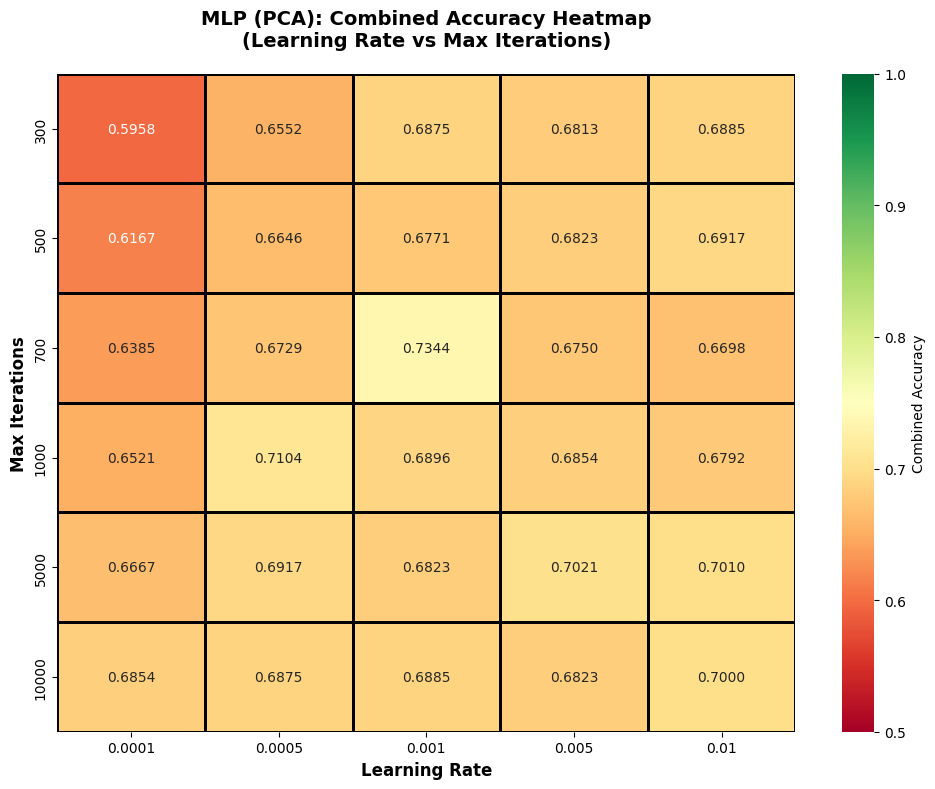

Generating per-class accuracy heatmaps...


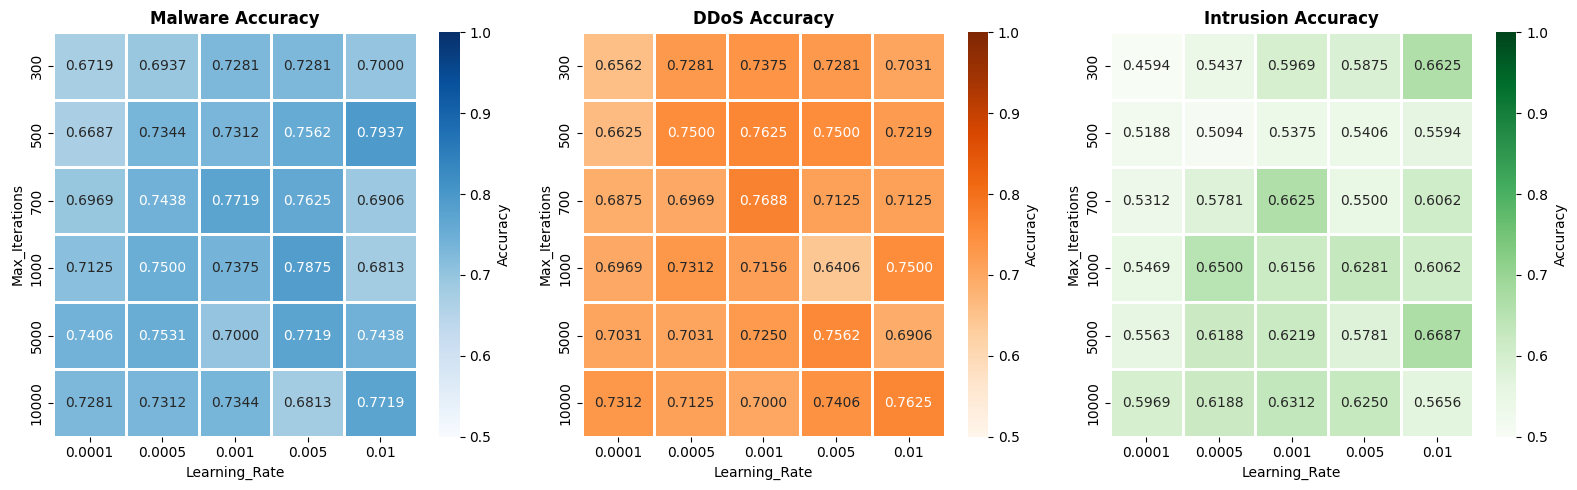


STEP 6: SUMMARY TABLE

 Learning_Rate  Max_Iterations  Train_Accuracy  Malware_Accuracy  DDoS_Accuracy  Intrusion_Accuracy  Combined_Accuracy  Macro_F1  Training_Time
        0.0001             300        0.766146          0.703125       0.712500            0.559375           0.658333  0.657061       2.476863
        0.0001             500        0.816146          0.750000       0.740625            0.603125           0.697917  0.696644       3.758263
        0.0001             700        0.842708          0.728125       0.718750            0.546875           0.664583  0.662659       5.174608
        0.0001            1000        0.894010          0.781250       0.718750            0.646875           0.715625  0.715047       7.388392
        0.0001            5000        0.935677          0.731250       0.746875            0.625000           0.701042  0.700537      11.970667
        0.0001           10000        0.951823          0.731250       0.734375            0.640625           0.

In [393]:
"""
MLP HYPERPARAMETER TUNING WITH PCA
Test different learning rates and max iterations to find the best combination
for MLP using PCA-reduced features
"""

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("MLP HYPERPARAMETER TUNING WITH PCA")
print("="*80)

# ===== ASSUMPTION =====
# You have already completed PCA and have:
# - X_train_pca (training data with PCA components)
# - y_train_combined (training labels)
# - X_test_malware_pca, X_test_ddos_pca, X_test_intrusion_pca
# - y_test_malware, y_test_ddos, y_test_intrusion

# ===== DEFINE PARAMETER RANGES =====
print("\n" + "="*80)
print("STEP 1: DEFINE PARAMETER RANGES TO TEST")
print("="*80)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
max_iterations = [300, 500, 700, 1000, 5000, 10000]

print(f"\nLearning rates to test: {learning_rates}")
print(f"Max iterations to test: {max_iterations}")
print(f"Total combinations: {len(learning_rates) * len(max_iterations)}")
print(f"Training data shape: {X_train_pca.shape}")
print(f"Number of PCA components: {X_train_pca.shape[1]}")

# ===== TEST ALL COMBINATIONS =====
print("\n" + "="*80)
print("STEP 2: TRAIN AND TEST ALL COMBINATIONS")
print("="*80)

results = []
total_tests = len(learning_rates) * len(max_iterations)
current_test = 0

for lr in learning_rates:
    for max_iter in max_iterations:
        current_test += 1
        print(f"\n[{current_test}/{total_tests}] Testing: lr={lr}, max_iter={max_iter}")
        
        # Create MLP model
        mlp_model = MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation='relu',
            solver='adam',
            learning_rate_init=lr,
            max_iter=max_iter,
            # early_stopping=True,
            # validation_fraction=0.1,
            # n_iter_no_change=10,
            # random_state=42,
            verbose=0
        )
        
        # Train model
        start_time = time.time()
        mlp_model.fit(X_train_pca, y_train_combined)
        training_time = time.time() - start_time
        
        # Make predictions on training data
        y_train_pred = mlp_model.predict(X_train_pca)
        train_accuracy = accuracy_score(y_train_combined, y_train_pred)
        
        # Make predictions on test data (individual attack types)
        y_pred_malware = mlp_model.predict(X_test_malware_pca)
        y_pred_ddos = mlp_model.predict(X_test_ddos_pca)
        y_pred_intrusion = mlp_model.predict(X_test_intrusion_pca)
        
        # Calculate accuracy for each attack type
        malware_accuracy = accuracy_score(y_test_malware, y_pred_malware)
        ddos_accuracy = accuracy_score(y_test_ddos, y_pred_ddos)
        intrusion_accuracy = accuracy_score(y_test_intrusion, y_pred_intrusion)
        
        # Combine all test predictions and labels
        y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
        y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
        
        # Calculate combined accuracy and F1 score
        combined_accuracy = accuracy_score(y_test_all, y_pred_all)
        macro_f1 = f1_score(y_test_all, y_pred_all, average='macro')
        
        # Print results for this combination
        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Combined Test Accuracy: {combined_accuracy:.4f}")
        print(f"  Training Time: {training_time:.2f}s")
        
        # Store results
        results.append({
            'Learning_Rate': lr,
            'Max_Iterations': max_iter,
            'Training_Time': training_time,
            'Train_Accuracy': train_accuracy,
            'Malware_Accuracy': malware_accuracy,
            'DDoS_Accuracy': ddos_accuracy,
            'Intrusion_Accuracy': intrusion_accuracy,
            'Combined_Accuracy': combined_accuracy,
            'Macro_F1': macro_f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# ===== FIND BEST CONFIGURATION =====
print("\n" + "="*80)
print("STEP 3: FIND BEST CONFIGURATION")
print("="*80)

best_idx = results_df['Combined_Accuracy'].idxmax()
best_config = results_df.loc[best_idx]

print(f"\n✓ BEST CONFIGURATION FOUND:")
print(f"  Learning Rate: {best_config['Learning_Rate']}")
print(f"  Max Iterations: {int(best_config['Max_Iterations'])}")
print(f"  Combined Test Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Training Time: {best_config['Training_Time']:.2f}s")
print(f"\n  Per-class Accuracy:")
print(f"    - Malware:    {best_config['Malware_Accuracy']:.4f}")
print(f"    - DDoS:       {best_config['DDoS_Accuracy']:.4f}")
print(f"    - Intrusion:  {best_config['Intrusion_Accuracy']:.4f}")
print(f"    - Macro F1:   {best_config['Macro_F1']:.4f}")

# ===== TOP 5 CONFIGURATIONS =====
print("\n" + "="*80)
print("STEP 4: TOP 5 CONFIGURATIONS")
print("="*80)

top_5 = results_df.nlargest(5, 'Combined_Accuracy')
print("\n" + top_5[['Learning_Rate', 'Max_Iterations', 'Combined_Accuracy', 
                     'Training_Time']].to_string(index=False))

# ===== VISUALIZATION 1: LINE PLOTS =====
print("\n" + "="*80)
print("STEP 5: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy vs Learning Rate
ax = axes[0]
for max_iter in max_iterations:
    subset = results_df[results_df['Max_Iterations'] == max_iter]
    ax.plot(subset['Learning_Rate'], subset['Combined_Accuracy'], 
            marker='o', label=f'max_iter={max_iter}', linewidth=2, markersize=8)

ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP (PCA): Accuracy vs Learning Rate', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_ylim([0.5, 1.0])

# Plot 2: Accuracy vs Max Iterations
ax = axes[1]
for lr in learning_rates:
    subset = results_df[results_df['Learning_Rate'] == lr]
    ax.plot(subset['Max_Iterations'], subset['Combined_Accuracy'], 
            marker='s', label=f'lr={lr}', linewidth=2, markersize=8)

ax.set_xlabel('Max Iterations', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP (PCA): Accuracy vs Max Iterations', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# ===== VISUALIZATION 2: HEATMAP =====
print("\nGenerating heatmap...")

# Create pivot table
heatmap_data = results_df.pivot_table(
    values='Combined_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Combined Accuracy'}, 
            vmin=0.5, vmax=1.0, linewidths=1, linecolor='black')

plt.title('MLP (PCA): Combined Accuracy Heatmap\n(Learning Rate vs Max Iterations)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Max Iterations', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 3: PER-CLASS ACCURACY HEATMAPS =====
print("Generating per-class accuracy heatmaps...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Malware accuracy
ax = axes[0]
malware_pivot = results_df.pivot_table(
    values='Malware_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(malware_pivot, annot=True, fmt='.4f', cmap='Blues', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Malware Accuracy', fontsize=12, fontweight='bold')

# DDoS accuracy
ax = axes[1]
ddos_pivot = results_df.pivot_table(
    values='DDoS_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(ddos_pivot, annot=True, fmt='.4f', cmap='Oranges', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('DDoS Accuracy', fontsize=12, fontweight='bold')

# Intrusion accuracy
ax = axes[2]
intrusion_pivot = results_df.pivot_table(
    values='Intrusion_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(intrusion_pivot, annot=True, fmt='.4f', cmap='Greens', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Intrusion Accuracy', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ===== SUMMARY TABLE =====
print("\n" + "="*80)
print("STEP 6: SUMMARY TABLE")
print("="*80)

summary_df_2_layers = results_df[['Learning_Rate', 'Max_Iterations', 'Train_Accuracy',
                          'Malware_Accuracy', 'DDoS_Accuracy', 'Intrusion_Accuracy',
                          'Combined_Accuracy', 'Macro_F1', 'Training_Time']].copy()

print("\n" + summary_df.to_string(index=False))

# ===== RECOMMENDATIONS =====
print("\n" + "="*80)
print("STEP 7: RECOMMENDATIONS")
print("="*80)

print(f"\n✓ USE THESE PARAMETERS FOR BEST ACCURACY (WITH PCA):")
print(f"  model = MLPClassifier(")
print(f"      hidden_layer_sizes=(128, 64, 32),")
print(f"      activation='relu',")
print(f"      solver='adam',")
print(f"      learning_rate_init={best_config['Learning_Rate']},")
print(f"      max_iter={int(best_config['Max_Iterations'])},")
print(f"      early_stopping=True,")
print(f"      validation_fraction=0.1,")
print(f"      n_iter_no_change=10,")
print(f"      random_state=42")
print(f"  )")
print(f"\nExpected Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"Training Time: {best_config['Training_Time']:.2f}s")

# ===== COMPARISON WITH FEATURE SELECTION =====
print("\n" + "="*80)
print("STEP 8: QUICK COMPARISON")
print("="*80)

print(f"\nBest accuracy achieved with PCA and these parameters:")
print(f"  Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Malware: {best_config['Malware_Accuracy']:.4f}")
print(f"  DDoS: {best_config['DDoS_Accuracy']:.4f}")
print(f"  Intrusion: {best_config['Intrusion_Accuracy']:.4f}")

print("\n✓ Now you can compare this with Feature Selection results!")

print("\n" + "="*80)
print("✓ HYPERPARAMETER TUNING COMPLETE!")
print("="*80)

MLP HYPERPARAMETER TUNING WITH PCA

STEP 1: DEFINE PARAMETER RANGES TO TEST

Learning rates to test: [0.0001, 0.0005, 0.001, 0.005, 0.01]
Max iterations to test: [300, 500, 700, 1000, 5000, 10000]
Total combinations: 30
Training data shape: (3840, 10)
Number of PCA components: 10

STEP 2: TRAIN AND TEST ALL COMBINATIONS

[1/30] Testing: lr=0.0001, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.5742
  Combined Test Accuracy: 0.5281
  Training Time: 0.79s

[2/30] Testing: lr=0.0001, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.5888
  Combined Test Accuracy: 0.5312
  Training Time: 1.32s

[3/30] Testing: lr=0.0001, max_iter=700


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.5974
  Combined Test Accuracy: 0.5500
  Training Time: 2.08s

[4/30] Testing: lr=0.0001, max_iter=1000


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.6263
  Combined Test Accuracy: 0.5781
  Training Time: 2.72s

[5/30] Testing: lr=0.0001, max_iter=5000
  Train Accuracy: 0.6544
  Combined Test Accuracy: 0.6021
  Training Time: 3.90s

[6/30] Testing: lr=0.0001, max_iter=10000
  Train Accuracy: 0.6477
  Combined Test Accuracy: 0.6062
  Training Time: 4.32s

[7/30] Testing: lr=0.0005, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.6643
  Combined Test Accuracy: 0.6177
  Training Time: 0.84s

[8/30] Testing: lr=0.0005, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.6854
  Combined Test Accuracy: 0.6167
  Training Time: 1.38s

[9/30] Testing: lr=0.0005, max_iter=700


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7094
  Combined Test Accuracy: 0.6417
  Training Time: 1.86s

[10/30] Testing: lr=0.0005, max_iter=1000
  Train Accuracy: 0.7273
  Combined Test Accuracy: 0.6427
  Training Time: 2.62s

[11/30] Testing: lr=0.0005, max_iter=5000
  Train Accuracy: 0.7490
  Combined Test Accuracy: 0.6417
  Training Time: 3.86s

[12/30] Testing: lr=0.0005, max_iter=10000
  Train Accuracy: 0.7401
  Combined Test Accuracy: 0.6417
  Training Time: 3.23s

[13/30] Testing: lr=0.001, max_iter=300


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7115
  Combined Test Accuracy: 0.6115
  Training Time: 0.85s

[14/30] Testing: lr=0.001, max_iter=500


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7260
  Combined Test Accuracy: 0.6177
  Training Time: 1.31s

[15/30] Testing: lr=0.001, max_iter=700


/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Accuracy: 0.7375
  Combined Test Accuracy: 0.6646
  Training Time: 1.93s

[16/30] Testing: lr=0.001, max_iter=1000
  Train Accuracy: 0.7552
  Combined Test Accuracy: 0.6521
  Training Time: 2.17s

[17/30] Testing: lr=0.001, max_iter=5000
  Train Accuracy: 0.7471
  Combined Test Accuracy: 0.6490
  Training Time: 1.86s

[18/30] Testing: lr=0.001, max_iter=10000
  Train Accuracy: 0.7635
  Combined Test Accuracy: 0.6625
  Training Time: 2.89s

[19/30] Testing: lr=0.005, max_iter=300
  Train Accuracy: 0.7375
  Combined Test Accuracy: 0.6271
  Training Time: 0.46s

[20/30] Testing: lr=0.005, max_iter=500
  Train Accuracy: 0.7737
  Combined Test Accuracy: 0.6521
  Training Time: 0.77s

[21/30] Testing: lr=0.005, max_iter=700
  Train Accuracy: 0.7648
  Combined Test Accuracy: 0.6500
  Training Time: 0.61s

[22/30] Testing: lr=0.005, max_iter=1000
  Train Accuracy: 0.7573
  Combined Test Accuracy: 0.6500
  Training Time: 0.50s

[23/30] Testing: lr=0.005, max_iter=5000
  Train Accuracy: 

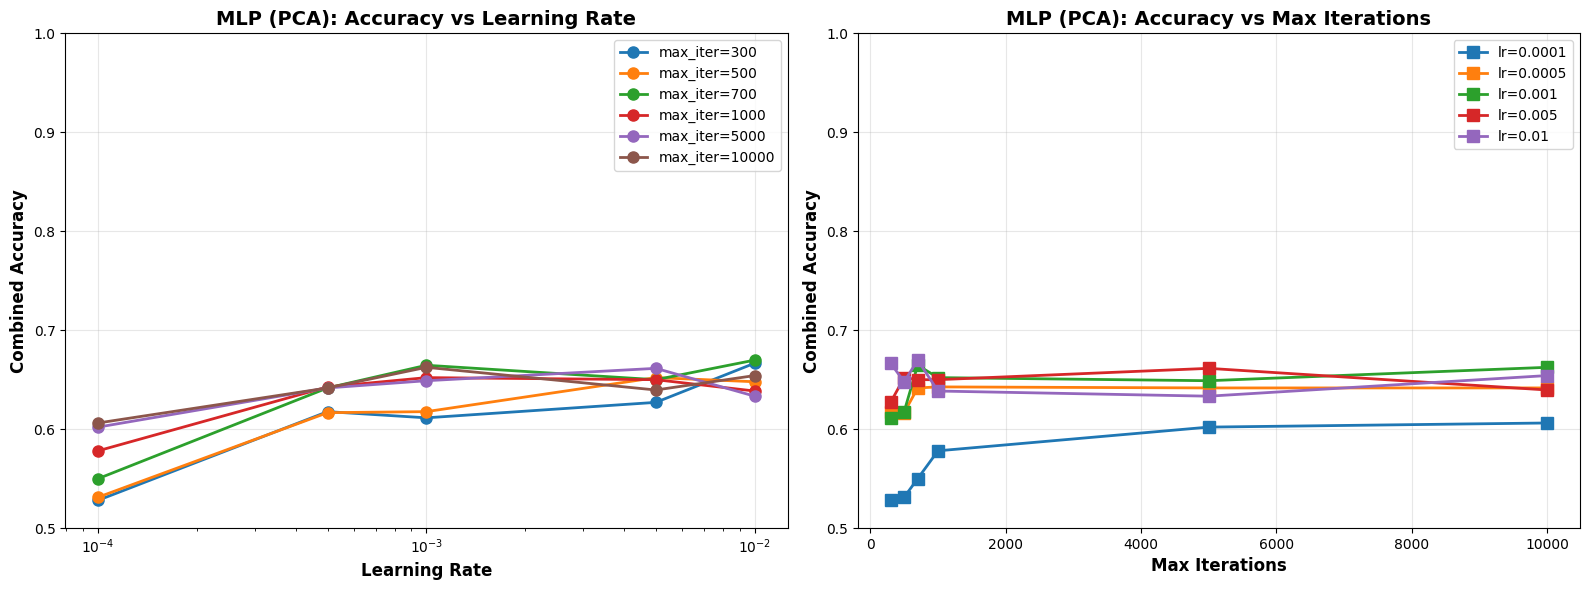


Generating heatmap...


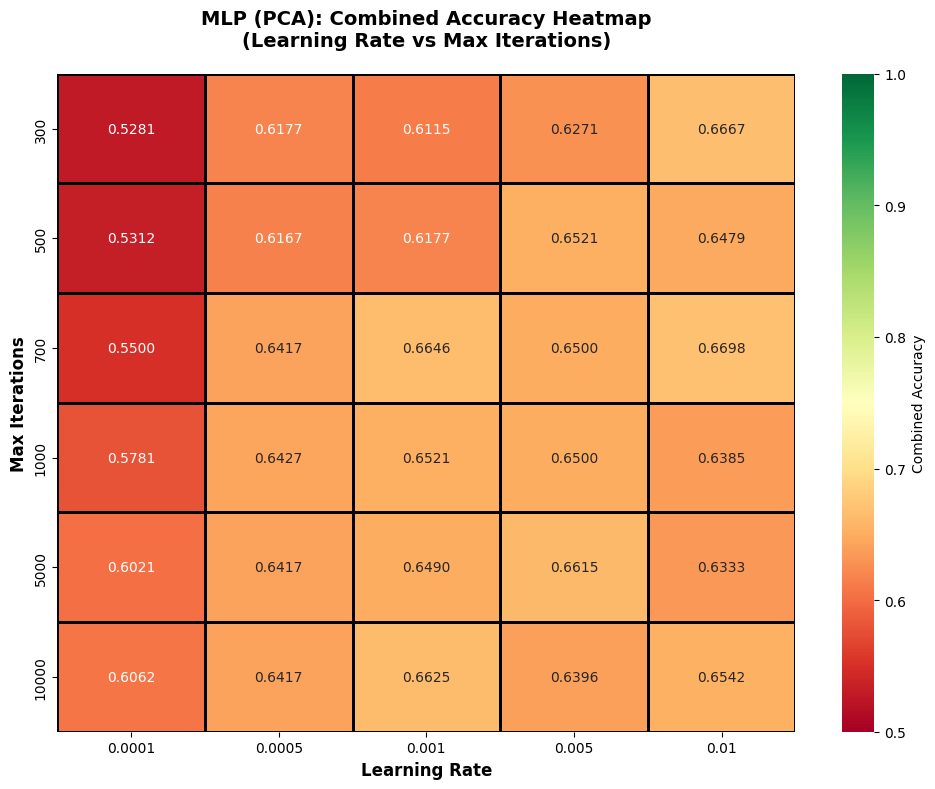

Generating per-class accuracy heatmaps...


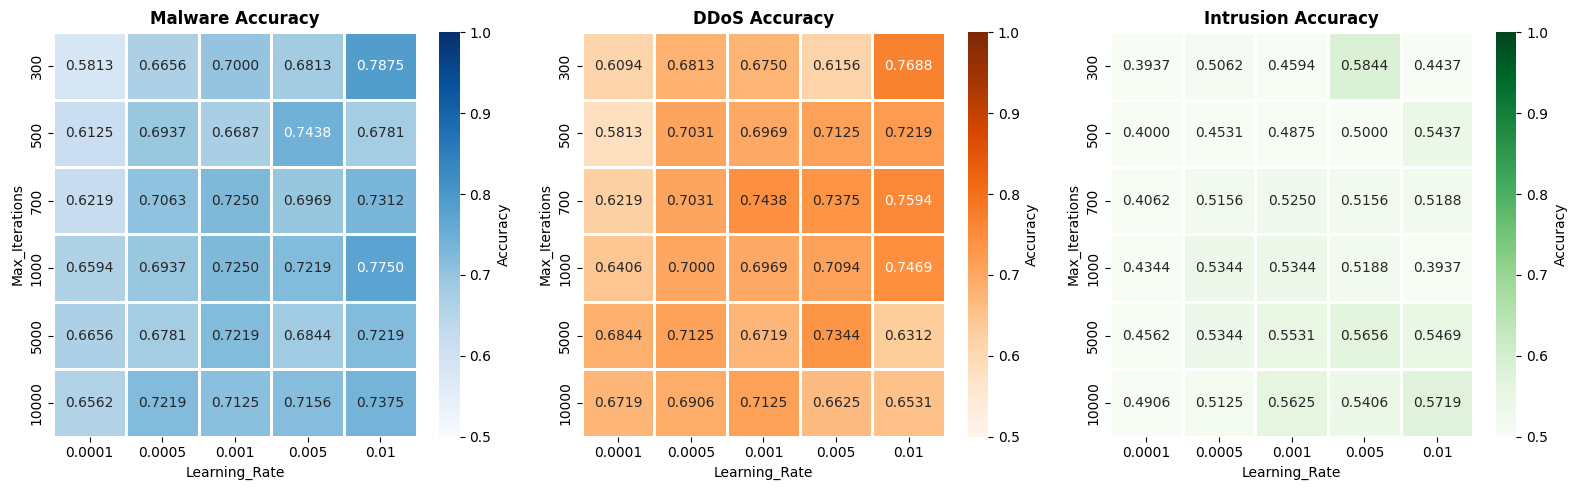


STEP 6: SUMMARY TABLE

 Learning_Rate  Max_Iterations  Train_Accuracy  Malware_Accuracy  DDoS_Accuracy  Intrusion_Accuracy  Combined_Accuracy  Macro_F1  Training_Time
        0.0001             300        0.766146          0.703125       0.712500            0.559375           0.658333  0.657061       2.476863
        0.0001             500        0.816146          0.750000       0.740625            0.603125           0.697917  0.696644       3.758263
        0.0001             700        0.842708          0.728125       0.718750            0.546875           0.664583  0.662659       5.174608
        0.0001            1000        0.894010          0.781250       0.718750            0.646875           0.715625  0.715047       7.388392
        0.0001            5000        0.935677          0.731250       0.746875            0.625000           0.701042  0.700537      11.970667
        0.0001           10000        0.951823          0.731250       0.734375            0.640625           0.

In [394]:
"""
MLP HYPERPARAMETER TUNING WITH PCA
Test different learning rates and max iterations to find the best combination
for MLP using PCA-reduced features
"""

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("MLP HYPERPARAMETER TUNING WITH PCA")
print("="*80)

# ===== ASSUMPTION =====
# You have already completed PCA and have:
# - X_train_pca (training data with PCA components)
# - y_train_combined (training labels)
# - X_test_malware_pca, X_test_ddos_pca, X_test_intrusion_pca
# - y_test_malware, y_test_ddos, y_test_intrusion

# ===== DEFINE PARAMETER RANGES =====
print("\n" + "="*80)
print("STEP 1: DEFINE PARAMETER RANGES TO TEST")
print("="*80)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
max_iterations = [300, 500, 700, 1000, 5000, 10000]

print(f"\nLearning rates to test: {learning_rates}")
print(f"Max iterations to test: {max_iterations}")
print(f"Total combinations: {len(learning_rates) * len(max_iterations)}")
print(f"Training data shape: {X_train_pca.shape}")
print(f"Number of PCA components: {X_train_pca.shape[1]}")

# ===== TEST ALL COMBINATIONS =====
print("\n" + "="*80)
print("STEP 2: TRAIN AND TEST ALL COMBINATIONS")
print("="*80)

results = []
total_tests = len(learning_rates) * len(max_iterations)
current_test = 0

for lr in learning_rates:
    for max_iter in max_iterations:
        current_test += 1
        print(f"\n[{current_test}/{total_tests}] Testing: lr={lr}, max_iter={max_iter}")
        
        # Create MLP model
        mlp_model = MLPClassifier(
            hidden_layer_sizes=(64),
            activation='relu',
            solver='adam',
            learning_rate_init=lr,
            max_iter=max_iter,
            # early_stopping=True,
            # validation_fraction=0.1,
            # n_iter_no_change=10,
            # random_state=42,
            verbose=0
        )
        
        # Train model
        start_time = time.time()
        mlp_model.fit(X_train_pca, y_train_combined)
        training_time = time.time() - start_time
        
        # Make predictions on training data
        y_train_pred = mlp_model.predict(X_train_pca)
        train_accuracy = accuracy_score(y_train_combined, y_train_pred)
        
        # Make predictions on test data (individual attack types)
        y_pred_malware = mlp_model.predict(X_test_malware_pca)
        y_pred_ddos = mlp_model.predict(X_test_ddos_pca)
        y_pred_intrusion = mlp_model.predict(X_test_intrusion_pca)
        
        # Calculate accuracy for each attack type
        malware_accuracy = accuracy_score(y_test_malware, y_pred_malware)
        ddos_accuracy = accuracy_score(y_test_ddos, y_pred_ddos)
        intrusion_accuracy = accuracy_score(y_test_intrusion, y_pred_intrusion)
        
        # Combine all test predictions and labels
        y_test_all = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])
        y_pred_all = np.concatenate([y_pred_malware, y_pred_ddos, y_pred_intrusion])
        
        # Calculate combined accuracy and F1 score
        combined_accuracy = accuracy_score(y_test_all, y_pred_all)
        macro_f1 = f1_score(y_test_all, y_pred_all, average='macro')
        
        # Print results for this combination
        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Combined Test Accuracy: {combined_accuracy:.4f}")
        print(f"  Training Time: {training_time:.2f}s")
        
        # Store results
        results.append({
            'Learning_Rate': lr,
            'Max_Iterations': max_iter,
            'Training_Time': training_time,
            'Train_Accuracy': train_accuracy,
            'Malware_Accuracy': malware_accuracy,
            'DDoS_Accuracy': ddos_accuracy,
            'Intrusion_Accuracy': intrusion_accuracy,
            'Combined_Accuracy': combined_accuracy,
            'Macro_F1': macro_f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# ===== FIND BEST CONFIGURATION =====
print("\n" + "="*80)
print("STEP 3: FIND BEST CONFIGURATION")
print("="*80)

best_idx = results_df['Combined_Accuracy'].idxmax()
best_config = results_df.loc[best_idx]

print(f"\n✓ BEST CONFIGURATION FOUND:")
print(f"  Learning Rate: {best_config['Learning_Rate']}")
print(f"  Max Iterations: {int(best_config['Max_Iterations'])}")
print(f"  Combined Test Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Training Time: {best_config['Training_Time']:.2f}s")
print(f"\n  Per-class Accuracy:")
print(f"    - Malware:    {best_config['Malware_Accuracy']:.4f}")
print(f"    - DDoS:       {best_config['DDoS_Accuracy']:.4f}")
print(f"    - Intrusion:  {best_config['Intrusion_Accuracy']:.4f}")
print(f"    - Macro F1:   {best_config['Macro_F1']:.4f}")

# ===== TOP 5 CONFIGURATIONS =====
print("\n" + "="*80)
print("STEP 4: TOP 5 CONFIGURATIONS")
print("="*80)

top_5 = results_df.nlargest(5, 'Combined_Accuracy')
print("\n" + top_5[['Learning_Rate', 'Max_Iterations', 'Combined_Accuracy', 
                     'Training_Time']].to_string(index=False))

# ===== VISUALIZATION 1: LINE PLOTS =====
print("\n" + "="*80)
print("STEP 5: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy vs Learning Rate
ax = axes[0]
for max_iter in max_iterations:
    subset = results_df[results_df['Max_Iterations'] == max_iter]
    ax.plot(subset['Learning_Rate'], subset['Combined_Accuracy'], 
            marker='o', label=f'max_iter={max_iter}', linewidth=2, markersize=8)

ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP (PCA): Accuracy vs Learning Rate', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_ylim([0.5, 1.0])

# Plot 2: Accuracy vs Max Iterations
ax = axes[1]
for lr in learning_rates:
    subset = results_df[results_df['Learning_Rate'] == lr]
    ax.plot(subset['Max_Iterations'], subset['Combined_Accuracy'], 
            marker='s', label=f'lr={lr}', linewidth=2, markersize=8)

ax.set_xlabel('Max Iterations', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Accuracy', fontsize=12, fontweight='bold')
ax.set_title('MLP (PCA): Accuracy vs Max Iterations', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# ===== VISUALIZATION 2: HEATMAP =====
print("\nGenerating heatmap...")

# Create pivot table
heatmap_data = results_df.pivot_table(
    values='Combined_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Combined Accuracy'}, 
            vmin=0.5, vmax=1.0, linewidths=1, linecolor='black')

plt.title('MLP (PCA): Combined Accuracy Heatmap\n(Learning Rate vs Max Iterations)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Max Iterations', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 3: PER-CLASS ACCURACY HEATMAPS =====
print("Generating per-class accuracy heatmaps...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Malware accuracy
ax = axes[0]
malware_pivot = results_df.pivot_table(
    values='Malware_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(malware_pivot, annot=True, fmt='.4f', cmap='Blues', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Malware Accuracy', fontsize=12, fontweight='bold')

# DDoS accuracy
ax = axes[1]
ddos_pivot = results_df.pivot_table(
    values='DDoS_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(ddos_pivot, annot=True, fmt='.4f', cmap='Oranges', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('DDoS Accuracy', fontsize=12, fontweight='bold')

# Intrusion accuracy
ax = axes[2]
intrusion_pivot = results_df.pivot_table(
    values='Intrusion_Accuracy',
    index='Max_Iterations',
    columns='Learning_Rate'
)
sns.heatmap(intrusion_pivot, annot=True, fmt='.4f', cmap='Greens', ax=ax, 
            cbar_kws={'label': 'Accuracy'}, vmin=0.5, vmax=1.0, linewidths=1)
ax.set_title('Intrusion Accuracy', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ===== SUMMARY TABLE =====
print("\n" + "="*80)
print("STEP 6: SUMMARY TABLE")
print("="*80)

summary_df_1_layer = results_df[['Learning_Rate', 'Max_Iterations', 'Train_Accuracy',
                          'Malware_Accuracy', 'DDoS_Accuracy', 'Intrusion_Accuracy',
                          'Combined_Accuracy', 'Macro_F1', 'Training_Time']].copy()

print("\n" + summary_df.to_string(index=False))

# ===== RECOMMENDATIONS =====
print("\n" + "="*80)
print("STEP 7: RECOMMENDATIONS")
print("="*80)

print(f"\n✓ USE THESE PARAMETERS FOR BEST ACCURACY (WITH PCA):")
print(f"  model = MLPClassifier(")
print(f"      hidden_layer_sizes=(128, 64, 32),")
print(f"      activation='relu',")
print(f"      solver='adam',")
print(f"      learning_rate_init={best_config['Learning_Rate']},")
print(f"      max_iter={int(best_config['Max_Iterations'])},")
print(f"      early_stopping=True,")
print(f"      validation_fraction=0.1,")
print(f"      n_iter_no_change=10,")
print(f"      random_state=42")
print(f"  )")
print(f"\nExpected Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"Training Time: {best_config['Training_Time']:.2f}s")

# ===== COMPARISON WITH FEATURE SELECTION =====
print("\n" + "="*80)
print("STEP 8: QUICK COMPARISON")
print("="*80)

print(f"\nBest accuracy achieved with PCA and these parameters:")
print(f"  Combined Accuracy: {best_config['Combined_Accuracy']:.4f}")
print(f"  Malware: {best_config['Malware_Accuracy']:.4f}")
print(f"  DDoS: {best_config['DDoS_Accuracy']:.4f}")
print(f"  Intrusion: {best_config['Intrusion_Accuracy']:.4f}")

print("\n✓ Now you can compare this with Feature Selection results!")

print("\n" + "="*80)
print("✓ HYPERPARAMETER TUNING COMPLETE!")
print("="*80)